In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel
import arviz as az

if not os.path.exists('./stan120'):
    os.makedirs('./stan120')

# Model Declarations

In [26]:
code_120 = """

data {
  int<lower=0> N; // Number of observations
  int<lower=0> N_miss; // Number of missing observations
  int<lower=0> P; // Covariate number
  int<lower=0> nyears;
  int<lower=0> nstations;

  array[N] int<lower=0> station;
  array[N] int<lower=0> year;
  array[N] int<lower=0> max_month;

  array[N_miss] int<lower=0> station_miss;
  array[N_miss] int<lower=0> year_miss;
  array[N_miss] int<lower=0> max_month_miss;
  
  array[N] int<lower=0> y; // Count data

  matrix[N, P] X; // Predictor matrix
  matrix[N_miss, P] X_miss; // Predictor matrix

  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
  matrix[nstations,nstations] H = exp(-(1/phi) * distances);
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years
  vector[nstations] w; //Random zero-mean effect for the space model
  real<lower = 0> sigma;
  real<lower = 0> sigma0;
}

transformed parameters {
  vector[N] lambda;
  vector[N] fix_eff;
  vector[N] intercept;

  vector[N_miss] lambda_miss;
  vector[N_miss] fix_eff_miss;
  vector[N_miss] intercept_miss;

  matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
  matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


  fix_eff = X * beta;
  intercept = xi[year] + eta[station] + w[station];

  lambda = exp(fix_eff + intercept);

  fix_eff_miss = X_miss * beta;
  intercept_miss = xi[year_miss] + eta[station_miss] + w[station_miss];

  lambda_miss = exp(fix_eff_miss + intercept_miss);

  /*
  for (i in 1:N) {
    if (lambda[i] > max_month[i]) {
      lambda[i] = max_month[i];
    }
  }

  for (i in 1:N_miss) {
    if (lambda_miss[i] > max_month_miss[i]) {
      lambda_miss[i] = max_month_miss[i];
    }
  }
  */
}

model {
  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, sigma0);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma0 ~ inv_gamma(2, 2);
}

generated quantities {
  vector[N] log_lik;
  vector[N] y_pred;
  vector[N_miss] y_pred_miss;

  /*
  for (i in 1:N) {
    real sum_p = 0;
    real u = uniform_rng(0, 1);
    for (b in 0:max_month[i]) {
      sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
      if (sum_p >= u) {
        y_pred[i] = b;
        break;
      }
    }
  }
  */

  for(i in 1:N){
    log_lik [ i ] = poisson_lpmf (y[i] | lambda[i]);
    y_pred[i] = poisson_rng(lambda[i]);
  }

  for(i in 1:N_miss){
    y_pred_miss[i] = poisson_rng(lambda_miss[i]);
  }
}

"""

stan_file = "./stan120/model_120.stan"

with open(stan_file, "w") as f:
    print(code_120, file=f)

In [27]:
code_120_dummy = """

data {
  int<lower=0> N; // Number of observations
  int<lower=0> N_miss; // Number of missing observations
  int<lower=0> P; // Covariate number
  int<lower=0> nyears;
  int<lower=0> nstations;

  array[N] int<lower=0> station;
  array[N] int<lower=0> year;
  array[N] int<lower=0> max_month;

  array[N_miss] int<lower=0> station_miss;
  array[N_miss] int<lower=0> year_miss;
  array[N_miss] int<lower=0> max_month_miss;
  
  array[N] int<lower=0> y; // Count data

  matrix[N, P] X; // Predictor matrix
  matrix[N_miss, P] X_miss; // Predictor matrix

  real phi;
  matrix[nstations, nstations] distances;

  vector[N] dummy_obs;
  vector[N_miss] dummy_miss;

  int<lower=0,upper=3> sampling_type;
}

transformed data {
  matrix[nstations,nstations] H = exp(-(1/phi) * distances);
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years
  vector[nstations] w; //Random zero-mean effect for the space model
  real<lower = 0> sigma;
  real<lower = 0> sigma0;

  vector[nstations] dummy_beta;
}

transformed parameters {
  vector[N] lambda;
  vector[N] fix_eff;
  vector[N] dummy_eff;
  vector[N] intercept;

  vector[N_miss] lambda_miss;
  vector[N_miss] fix_eff_miss;
  vector[N_miss] dummy_eff_miss;
  vector[N_miss] intercept_miss;

  matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
  matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


  fix_eff = X * beta;
  for (i in 1:N) {
    dummy_eff[i] = dummy_obs[i] * dummy_beta[station[i]];
  }
  intercept = xi[year] + eta[station] + w[station] + dummy_eff;
  lambda = exp(fix_eff + intercept);

  fix_eff_miss = X_miss * beta;
  for (i in 1:N_miss) {
    dummy_eff_miss[i] = dummy_miss[i] * dummy_beta[station_miss[i]];
  }
  intercept_miss = xi[year_miss] + eta[station_miss] + w[station_miss] + dummy_eff_miss;
  lambda_miss = exp(fix_eff_miss + intercept_miss);

  /*
  for (i in 1:N) {
    if (lambda[i] > max_month[i]) {
      lambda[i] = max_month[i];
    }
  }

  for (i in 1:N_miss) {
    if (lambda_miss[i] > max_month_miss[i]) {
      lambda_miss[i] = max_month_miss[i];
    }
  }
  */
}

model {
  beta ~ normal(0, 2);
  for (i in 1:N) {
    y[i] ~ poisson(lambda[i]);
  };

  xi ~ normal(0, 2);
  eta ~ normal(0, sigma0);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma0 ~ inv_gamma(2, 2);

  dummy_beta ~ normal(-1, 2);
}

generated quantities {
  vector[N] log_lik;
  vector[N] y_pred;
  vector[N_miss] y_pred_miss;

  for(i in 1:N) {
    log_lik [ i ] = poisson_lpmf (y[i] | lambda[i]);
  }

  if (sampling_type == 0) {
    for (i in 1:N) {
     y_pred[i] = poisson_rng(lambda[i]);
    }

    for (i in 1:N_miss) {
      y_pred_miss[i] = poisson_rng(lambda_miss[i]);
    }
  }
  
  if (sampling_type == 1) {
    for(i in 1:N){
    real y_temp = max_month[i] + 1;
      while (y_temp > max_month[i]) {
        y_temp = poisson_rng(lambda[i]);
      };
      y_pred[i] = y_temp;
    }

    for(i in 1:N_miss){
      real y_temp = max_month_miss[i] + 1;
      while (y_temp > max_month_miss[i]){
        y_temp = poisson_rng(lambda_miss[i]);
      };
      y_pred_miss[i] = y_temp;
    }
  }  

  if (sampling_type == 2) {
    for (i in 1:N) {
      if (y_pred[i] > max_month[i]) {
        y_pred[i] = max_month[i];
      }
    }

    for (i in 1:N_miss) {
      if (y_pred_miss[i] > max_month_miss[i]) {
        y_pred_miss[i] = max_month_miss[i];
      }
    }
  }
  
  if (sampling_type == 3) {
    for (i in 1:N) {
      real sum_p = 0;
      real u = uniform_rng(0, 1);
      for (b in 0:max_month[i]) {
        sum_p = sum_p + exp(poisson_lpmf(b | lambda[i]) - poisson_lcdf(max_month[i] | lambda[i]));
        if (sum_p >= u) {
          y_pred[i] = b;
          break;
        }
      }
    }

    for (i in 1:N_miss) {
      real sum_p = 0;
      real u = uniform_rng(0, 1);
      for (b in 0:max_month[i]) {
        sum_p = sum_p + exp(poisson_lpmf(b | lambda_miss[i]) - poisson_lcdf(max_month[i] | lambda_miss[i]));
        if (sum_p >= u) {
          y_pred_miss[i] = b;
          break;
        }
      }
    }
  }
  
}

"""

stan_file = "./stan120/model_120_dummy.stan"

with open(stan_file, "w") as f:
    print(code_120_dummy, file=f)

# Baseline Model

In [28]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")

Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

phi = 62/3
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [29]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X_obs = X.drop(index=rows_to_drop_Y)
Y_obs = Y.drop(index=rows_to_drop_Y)
X_miss = X.loc[rows_to_drop_Y,:]
Y_miss = Y.loc[rows_to_drop_Y,:]

#saving the indexes of the dataframes
X_obs_index = X_obs.index
Y_obs_index = Y_obs.index
X_miss_index = X_miss.index
Y_miss_index = Y_miss.index

# If you want to reset the index after dropping rows
X_obs = X_obs.reset_index(drop=True)
Y_obs = Y_obs.reset_index(drop=True)
X_miss = X_miss.reset_index(drop=True)
Y_miss = Y_miss.reset_index(drop=True)

In [30]:
stations_obs = X_obs.loc[:,'Station']
years_raw_obs = X_obs.loc[:,'Year']
months_raw_obs = X_obs.loc[:,'Month']
years_obs = X_obs.loc[:,'Year'] - 2009
unique_values_obs = sorted(set(stations_obs))
mapping_dict_obs = {value: index + 1 for index, value in enumerate(unique_values_obs)}
transformed_stations_obs = [mapping_dict_obs[value] for value in stations_obs]

transformed_stations_obs = pd.Series(transformed_stations_obs)
years_obs = pd.Series(years_obs)

stations_miss = X_miss.loc[:,'Station']
years_raw_miss = X_miss.loc[:,'Year']
months_raw_miss = X_miss.loc[:,'Month']
years_miss = X_miss.loc[:,'Year'] - 2009
unique_values_miss = sorted(set(stations_miss))
mapping_dict_miss = {value_miss: index_miss + 1 for index_miss, value_miss in enumerate(unique_values_miss)}
transformed_stations_miss = [mapping_dict_miss[value_miss] for value_miss in stations_miss]

transformed_stations_miss = pd.Series(transformed_stations_miss)
years_miss = pd.Series(years_miss)

day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month_obs = []
max_month_miss = []

for i in range(0,X_obs.shape[0]):
    max_month_obs.append(day_in_month[X_obs['Month'][i]-1])

for i in range(0,X_miss.shape[0]):
    max_month_miss.append(day_in_month[X_miss['Month'][i]-1])

max_month_obs = pd.Series(max_month_obs)
max_month_miss = pd.Series(max_month_miss)

In [31]:
X_obs = X_obs.drop(['Year','Station','Month'], axis  = 1)
X_miss = X_miss.drop(['Year','Station','Month'], axis  = 1)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_obs_std = scaler.fit_transform(X_obs)
X_obs_std = pd.DataFrame(X_obs_std, columns=X_obs.columns)
X_obs_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_obs_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_obs_std.loc[:,"type_rural"] = pd.to_numeric(X_obs_std.loc[:,"type_rural"]).astype('Int64')
X_obs_std.loc[:,"type_urban"] = pd.to_numeric(X_obs_std.loc[:,"type_urban"]).astype('Int64')

X_miss_std = scaler.fit_transform(X_miss)
X_miss_std = pd.DataFrame(X_miss_std, columns=X_miss.columns)
X_miss_std.loc[:,"type_rural"] = X_miss.loc[:,"type_rural"]
X_miss_std.loc[:,"type_urban"] = X_miss.loc[:,"type_urban"]
X_miss_std.loc[:,"type_rural"] = pd.to_numeric(X_miss_std.loc[:,"type_rural"]).astype('Int64')
X_miss_std.loc[:,"type_urban"] = pd.to_numeric(X_miss_std.loc[:,"type_urban"]).astype('Int64')

In [33]:
model_120 = CmdStanModel(stan_file="./stan120/model_120.stan")

data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances
}

fit_120 = model_120.sample(data=data_120, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120 = az.from_cmdstanpy(fit_120)

04:06:15 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan120\model_120.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan120\model_120.exe


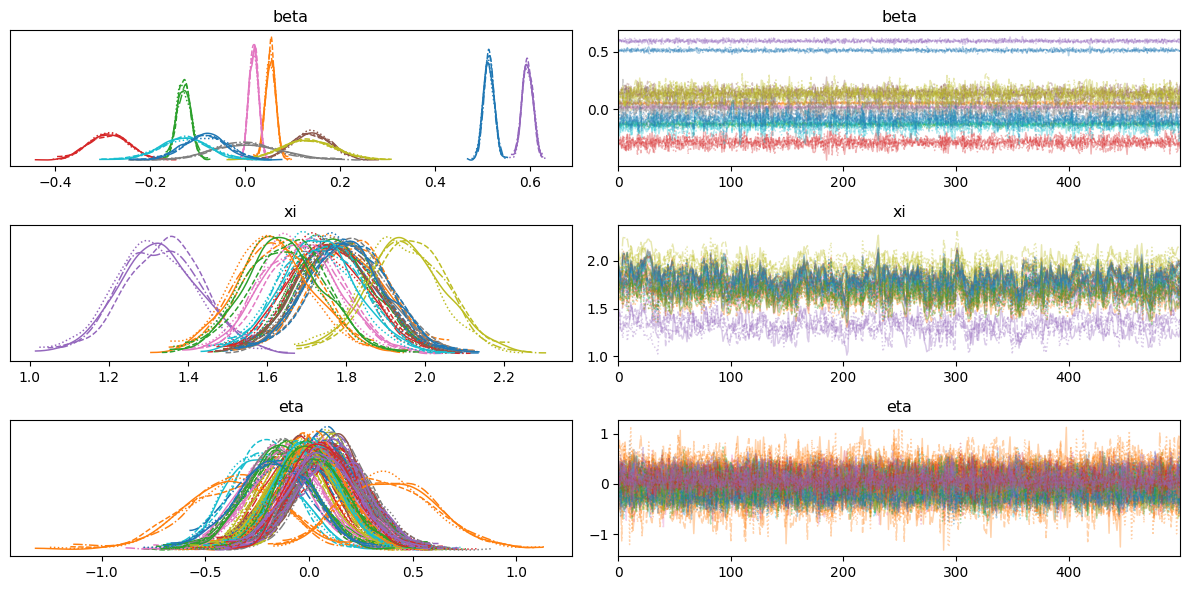

In [ ]:
az.plot_trace(posterior_120, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [ ]:
posterior_120_med = posterior_120.posterior.median(dim=['chain', 'draw'])

In [ ]:
y_star = posterior_120.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_120.posterior.y_pred.quantile(0.975, dim=["chain", "draw"])
y_star_low = posterior_120.posterior.y_pred.quantile(0.025, dim=["chain", "draw"])


y_star_miss = posterior_120.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_120.posterior.y_pred_miss.quantile(0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_120.posterior.y_pred_miss.quantile(0.025, dim=["chain", "draw"])

# Recontructing original ordering of the data
y_star_total = pd.concat([pd.Series(y_star, index=Y_obs_index), pd.Series(y_star_miss, index=Y_miss_index)]).sort_index()
y_star_up_total = pd.concat([pd.Series(y_star_up, index=Y_obs_index), pd.Series(y_star_up_miss, index=Y_miss_index)]).sort_index()
y_star_low_total = pd.concat([pd.Series(y_star_low, index=Y_obs_index), pd.Series(y_star_low_miss, index=Y_miss_index)]).sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'ceil'

In [ ]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[   1    3    6 ... 3832 3837 3839]
(1918,)


In [ ]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

[   3   79  409  591  625  646  674  867  913 1086 1121 1170 1177 1353
 1387 1435 1533 1616 1919 1965 2091 2139 2175 2387 2599 2620 2648 2655
 2667 2686 2699 2700 2707 2713 2714 2734 2735 2906 2913 2996 3022 3035
 3084 3122 3341 3376 3396 3423 3545 3591 3629 3757 3788]
(53,)
[   3  391  410  422  429  478  513  585  599  674  695  701  769  770
  876  884  920  950 1016 1021 1032 1222 1407 1408 1527 1540 1889 1983
 2026 2119 2140 2221 2251 2399 2580 2613 2648 2655 2663 2700 2718 2734
 2735 2749 2832 2833 2839 2920 3014 3028 3042 3095 3140 3161 3423 3430
 3522 3526 3607 3608 3694]
(61,)


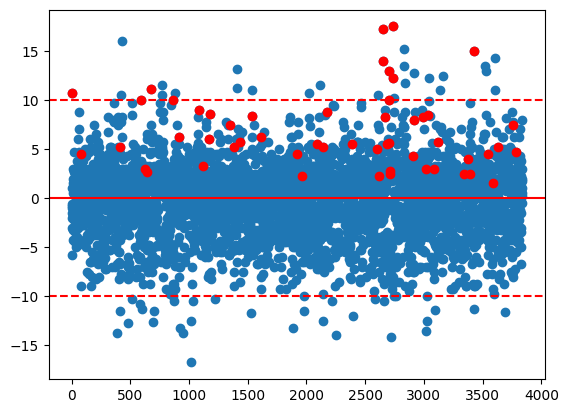

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals, axis=0)
print(mae)
mse = np.mean(residuals**2, axis=0)
print(mse)

NameError: name 'np' is not defined

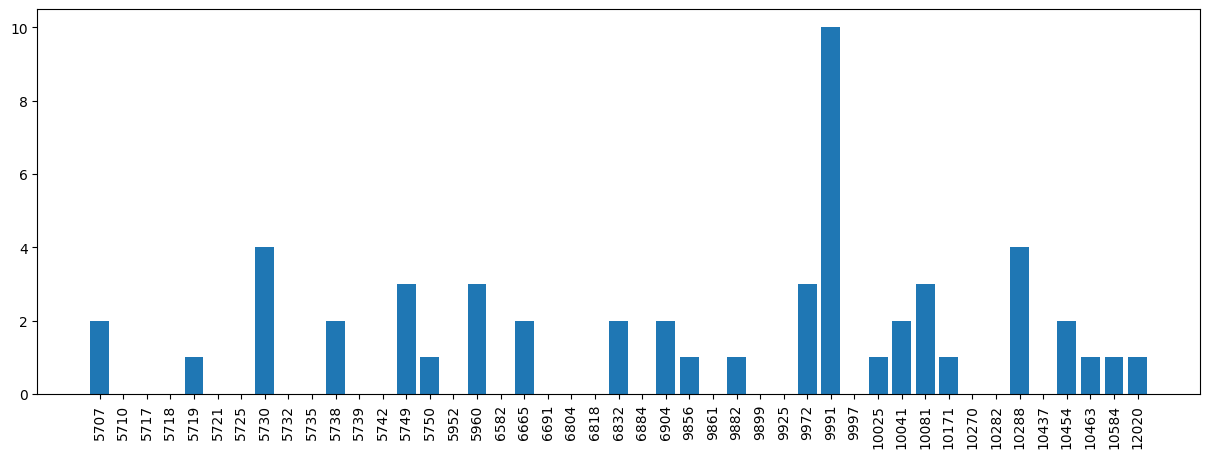

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

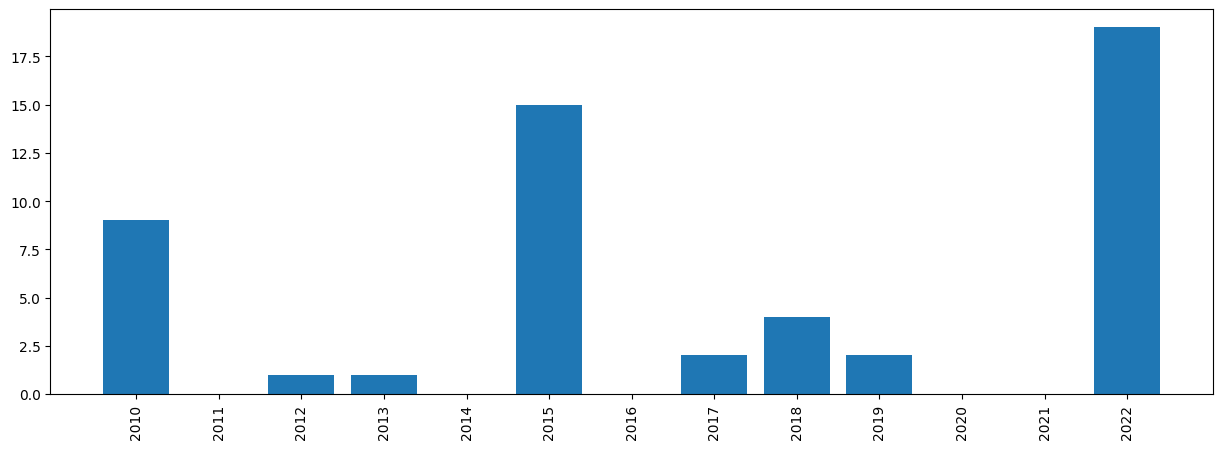

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

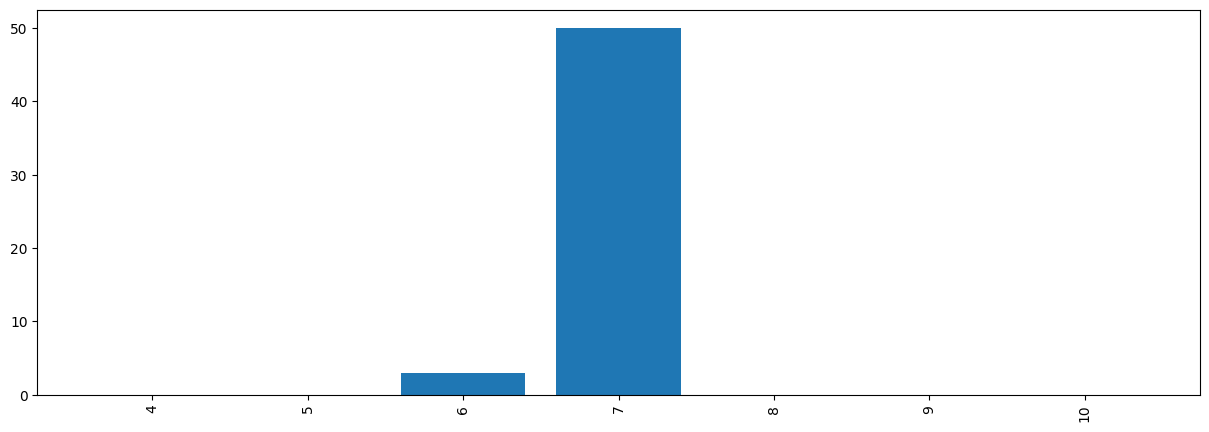

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month = outliers_per_month.sort_index()
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

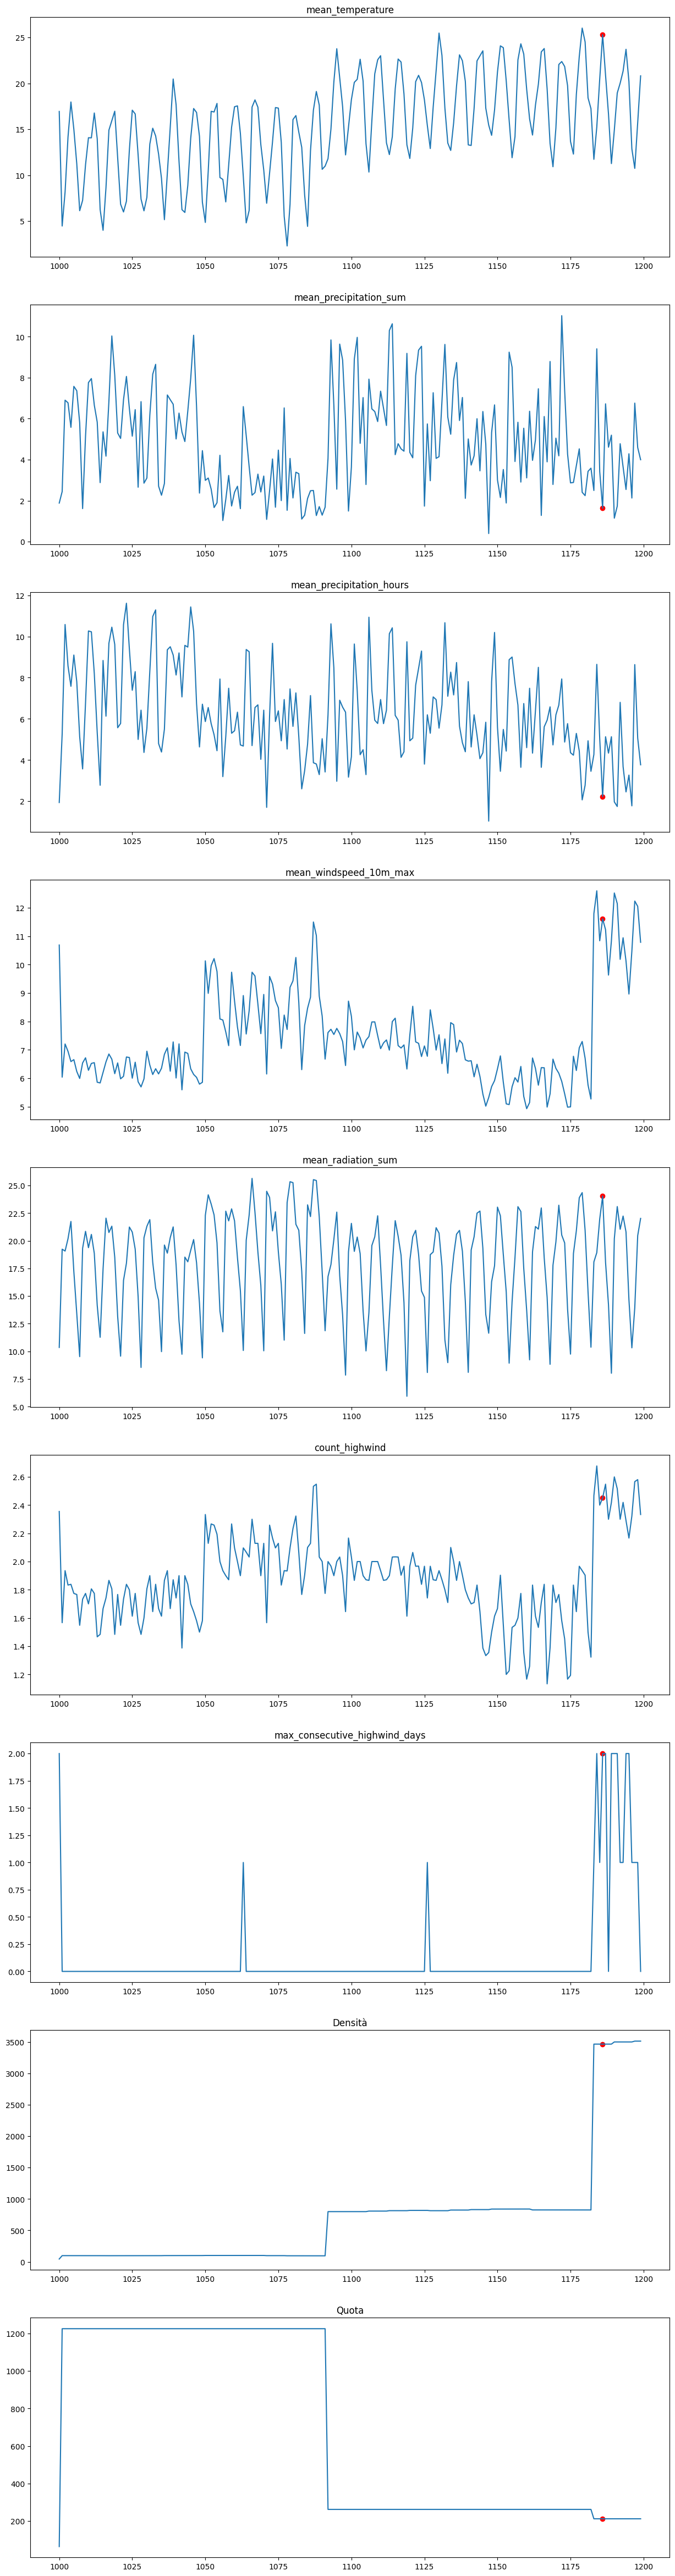

In [ ]:
# Plotting covariates around the outliers
X_data = X.drop(['Year','Station','Month'], axis  = 1)
station_num_to_plot = -1 # Change this to plot different stations, -1 to choose manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
fig, axs = plt.subplots(9, 1, figsize=(15, 60))
for i in range(0,9):
    axs[i].plot(xx, X_data.iloc[:,i][xx])
    axs[i].scatter(np.intersect1d(X_obs_index[idx_over_max],xx), X_data.iloc[:,i][np.intersect1d(X_obs_index[idx_over_max],xx)], color='r')
    axs[i].set_title(X_data.columns[i])
plt.show()

# Models with an added dummy variable

In [ ]:
years_to_repeat = [2010, 2015, 2022]
station_to_repeat = [9991]
months_to_repeat = [7]

dummy_july = np.zeros(X.shape[0])
dummy_temp = np.zeros(X.shape[0])
dummy_prec_sum = np.zeros(X.shape[0])
dummy_prec_hours = np.zeros(X.shape[0])
dummy_rad = np.zeros(X.shape[0])
dummy_cov_inter = np.zeros(X.shape[0])
dummy_tot_inter = np.zeros(X.shape[0])

T_threshold = np.percentile(X['mean_temperature'], 95)
P_sum_threshold = np.percentile(X['mean_precipitation_sum'], 5)
P_hours_threshold = np.percentile(X['mean_precipitation_hours'], 5)
Rad_threshold = np.percentile(X['mean_radiation_sum'], 95)

idx_july = np.where(X['Month'].isin(months_to_repeat))[0]
idx_temp = np.where(X['mean_temperature'] >= T_threshold)[0]
idx_p_sum = np.where(X['mean_precipitation_sum'] <= P_sum_threshold)[0]
idx_p_hours = np.where(X['mean_precipitation_hours'] <= P_hours_threshold)[0]
idx_rad = np.where(X['mean_radiation_sum'] >= Rad_threshold)[0]
idx_cov_inter = np.unique(np.concatenate((idx_temp, idx_p_sum, idx_p_hours, idx_rad)))
idx_tot_inter = np.unique(np.concatenate((idx_july, idx_cov_inter)))

dummy_july[idx_july] = 1
dummy_temp[idx_temp] = 1
dummy_prec_sum[idx_p_sum] = 1
dummy_prec_hours[idx_p_hours] = 1
dummy_rad[idx_rad] = 1
dummy_cov_inter[idx_cov_inter] = 1
dummy_tot_inter[idx_tot_inter] = 1

dummy_july_obs = pd.Series(dummy_july[X_obs_index])
dummy_temp_obs = pd.Series(dummy_temp[X_obs_index])
dummy_prec_sum_obs = pd.Series(dummy_prec_sum[X_obs_index])
dummy_prec_hours_obs = pd.Series(dummy_prec_hours[X_obs_index])
dummy_rad_obs = pd.Series(dummy_rad[X_obs_index])
dummy_cov_inter_obs = pd.Series(dummy_cov_inter[X_obs_index])
dummy_tot_inter_obs = pd.Series(dummy_tot_inter[X_obs_index])

dummy_july_miss = pd.Series(dummy_july[X_miss_index])
dummy_temp_miss = pd.Series(dummy_temp[X_miss_index])
dummy_prec_sum_miss = pd.Series(dummy_prec_sum[X_miss_index])
dummy_prec_hours_miss = pd.Series(dummy_prec_hours[X_miss_index])
dummy_rad_miss = pd.Series(dummy_rad[X_miss_index])
dummy_cov_inter_miss = pd.Series(dummy_cov_inter[X_miss_index])
dummy_tot_inter_miss = pd.Series(dummy_tot_inter[X_miss_index])

In [ ]:
model_120_dummy = CmdStanModel(stan_file="./stan120/model_120_dummy.stan")

03:31:05 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan120\model_120_dummy.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan120\model_120_dummy.exe
03:32:48 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan120\model_120_dummy.exe


### Dummy for july

In [ ]:
data_120_july = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs,
    "dummy_miss": dummy_july_miss,
    "sampling_type": 0  # 0 for poisson, 1 for rejection, 2 for hard cap, 3 for truncated poisson
}

fit_120_july = model_120_dummy.sample(data=data_120_july, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_july = az.from_cmdstanpy(fit_120_july)

03:32:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 02:16 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 03:14 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 04:02 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 04:43 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████▊    | 05:33 Iteration: 500 / 1000 [ 50%]  (Warmup)





chain 1 |██████▋   | 06:16 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |████████▎ | 07:34 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 08:11 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 09:00 Iteration: 900 / 1000 [ 90%]  (Sampling)





chain 1 |██████████| 10:16 Sampling completed                      
chain 2 |██████████| 10:16 Sampling completed                      
chain 3 |██████████| 10:16 Sampling completed                      
chain 4 |██████████| 10:16 Sampling completed                      


03:43:11 - cmdstanpy - INFO - CmdStan done processing.
03:43:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dummy.stan', line 59, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dummy.stan', line 59, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dummy.stan', line 59, column 2 to column 63)
Exception: cholesky_de

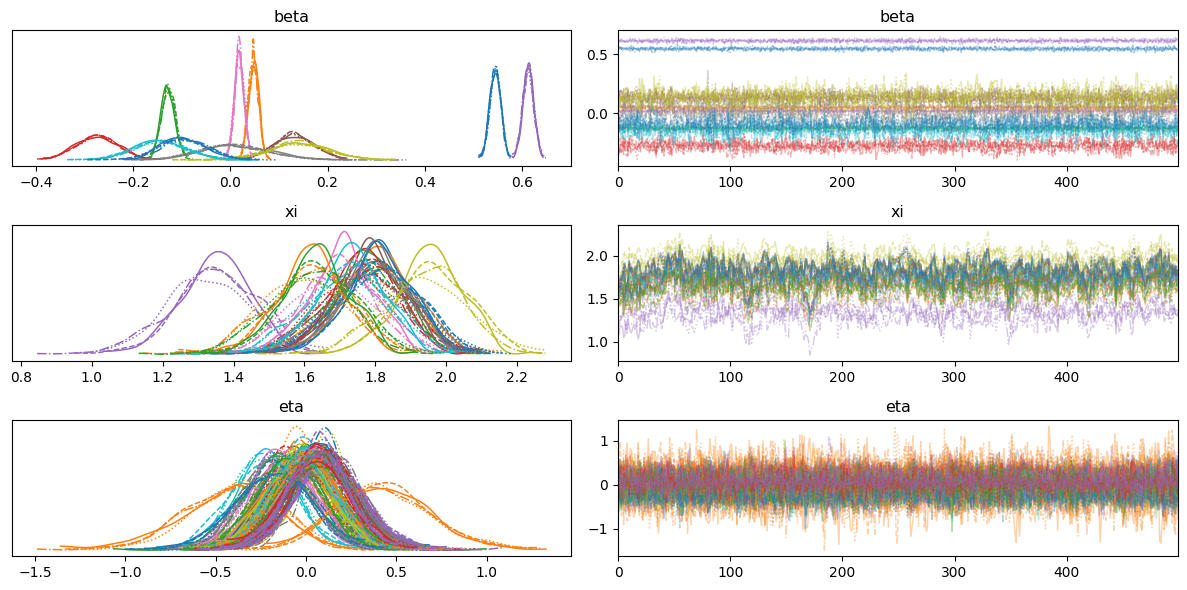

In [ ]:
az.plot_trace(posterior_120_july, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_july

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

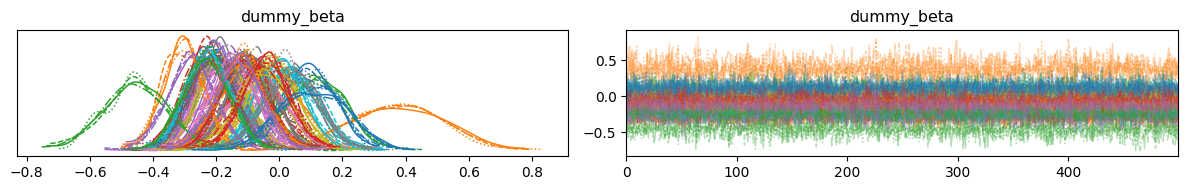

In [ ]:
az.plot_trace(posterior_120_july, var_names=['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_july_med = posterior_120_july.posterior.median(dim=['chain', 'draw'])
posterior_120_july_med

<xarray.Dataset>
Dimensions:               (beta_dim_0: 11, eta_dim_0: 45, xi_dim_0: 13,
                           w_dim_0: 45, dummy_beta_dim_0: 45,
                           lambda_dim_0: 3840, fix_eff_dim_0: 3840,
                           dummy_eff_dim_0: 3840, intercept_dim_0: 3840,
                           lambda_miss_dim_0: 255, fix_eff_miss_dim_0: 255,
                           dummy_eff_miss_dim_0: 255,
                           intercept_miss_dim_0: 255, Sigma_s_dim_0: 45,
                           Sigma_s_dim_1: 45, Lw_dim_0: 45, Lw_dim_1: 45,
                           y_pred_dim_0: 3840, y_pred_miss_dim_0: 255)
Coordinates: (12/19)
  * beta_dim_0            (beta_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10
  * eta_dim_0             (eta_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * xi_dim_0              (xi_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * w_dim_0               (w_dim_0) int32 0 1 2 3 4 5 6 ... 38 39 40 41 42 43 44
  * dummy_beta_dim_0      (dummy_beta_dim_0) int32 0 1 2 3 4 ... 40 41 42 43 44
  * lambda_dim_0          (lambda_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
    ...                    ...
  * Sigma_s_dim_0         (Sigma_s_dim_0) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Sigma_s_dim_1         (Sigma_s_dim_1) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Lw_dim_0              (Lw_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * Lw_dim_1              (Lw_dim_1) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * y_pred_dim_0          (y_pred_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * y_pred_miss_dim_0     (y_pred_miss_dim_0) int32 0 1 2 3 ... 251 252 253 254
Data variables: (12/19)
    beta                  (beta_dim_0) float64 0.5453 0.04786 ... -0.09733
    eta                   (eta_dim_0) float64 0.103 -0.0456 ... 0.05269 0.06294
    xi                    (xi_dim_0) float64 1.8 1.797 1.774 ... 1.616 1.627
    w                     (w_dim_0) float64 0.2909 0.08537 ... 0.2264 0.1016
    sigma                 float64 0.311
    sigma0                float64 0.24
    ...                    ...
    dummy_eff_miss        (dummy_eff_miss_dim_0) float64 0.0 0.0 0.0 ... 0.0 0.0
    intercept_miss        (intercept_miss_dim_0) float64 1.746 2.196 ... 2.02
    Sigma_s               (Sigma_s_dim_0, Sigma_s_dim_1) float64 0.09671 ... ...
    Lw                    (Lw_dim_0, Lw_dim_1) float64 0.311 0.0 ... 0.2475
    y_pred                (y_pred_dim_0) float64 3.0 5.0 16.0 ... 15.0 3.0 1.0
    y_pred_miss           (y_pred_miss_dim_0) float64 6.0 4.0 5.0 ... 1.0 10.0

In [ ]:
y_star = posterior_120_july.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_120_july.posterior.y_pred.quantile(0.975, dim=["chain", "draw"])
y_star_low = posterior_120_july.posterior.y_pred.quantile(0.025, dim=["chain", "draw"])


y_star_miss = posterior_120_july.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_120_july.posterior.y_pred_miss.quantile(0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_120_july.posterior.y_pred_miss.quantile(0.025, dim=["chain", "draw"])

# Recontructing original ordering of the data
y_star_total = pd.concat([pd.Series(y_star, index=Y_obs_index), pd.Series(y_star_miss, index=Y_miss_index)]).sort_index()
y_star_up_total = pd.concat([pd.Series(y_star_up, index=Y_obs_index), pd.Series(y_star_up_miss, index=Y_miss_index)]).sort_index()
y_star_low_total = pd.concat([pd.Series(y_star_low, index=Y_obs_index), pd.Series(y_star_low_miss, index=Y_miss_index)]).sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()


NameError: name 'posterior_120' is not defined

In [ ]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21   34   83  145  154  165  173  227  234  309  350  351  362  363
  385  391  394  396  404  410  413  414  420  422  429  430  433  472
  478  479  481  482  486  488  493  512  513  519  581  582  585  588
  599  609  618  643  650  662  665  669  680  682  685  689  690  695
  701  718  753  757  769  770  771  774  775  781  799  802  807  824
  835  863  864  869  874  876  877  884  898  917  918  919  920  921
  931  950  955  962  984 1009 1012 1016 1019 1021 1022 1026 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1283 1317
 1329 1331 1341 1371 1384 1385 1407 1408 1409 1527 1535 1539 1540 1552
 1553 1563 1611 1631 1639 1647 1667 1765 1774 1786 1802 1824 1834 1848
 1859 1867 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978
 1983 1989 2008 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134
 2137 2140 2144 2180 2198 2221 2227 2234 2238 2241 2251 2291 2301 2315
 2327 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465
 2495 

In [ ]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

[   3  591  674  867 1387 2139 2387 2648 2655 2699 2713 2734 2735 2906
 3035 3122 3423 3545 3656 3757 3788]
(21,)
[ 391  410  429  478  585  599  695  701  769  770  876  884  920  950
 1016 1021 1222 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399
 2648 2666 2699 2718 2734 2749 2761 2832 2833 2839 2988 3014 3028 3095
 3140 3161 3522 3526 3607 3694]
(48,)


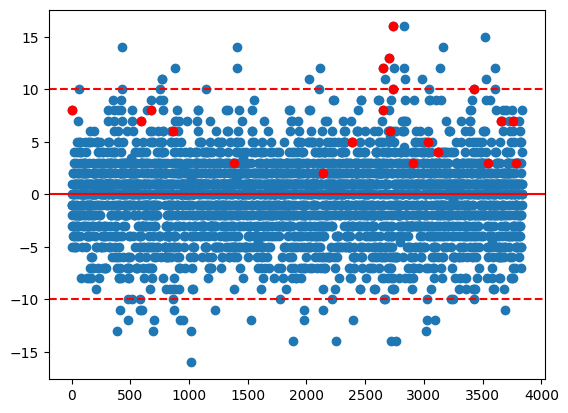

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.73658854)
<xarray.DataArray ()>
array(13.42923177)


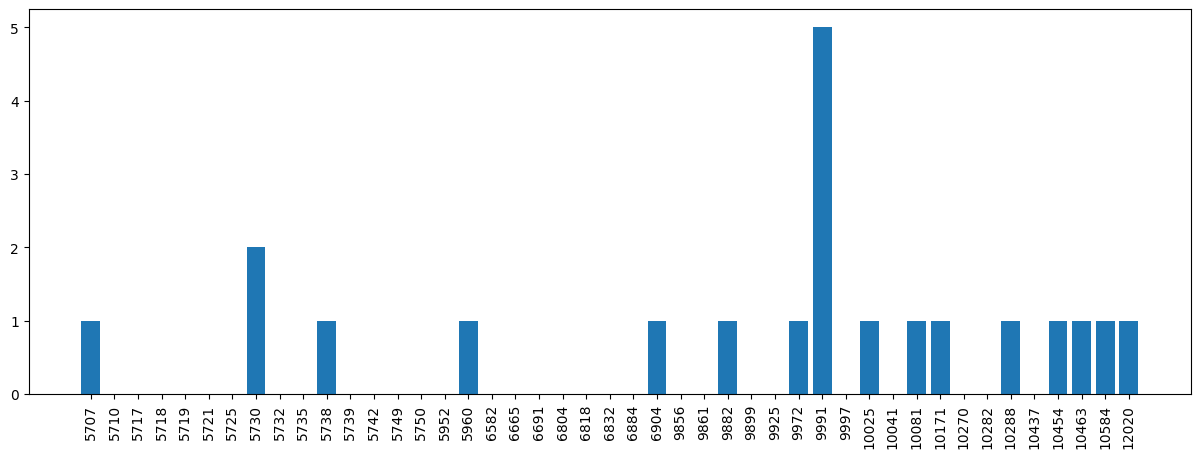

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

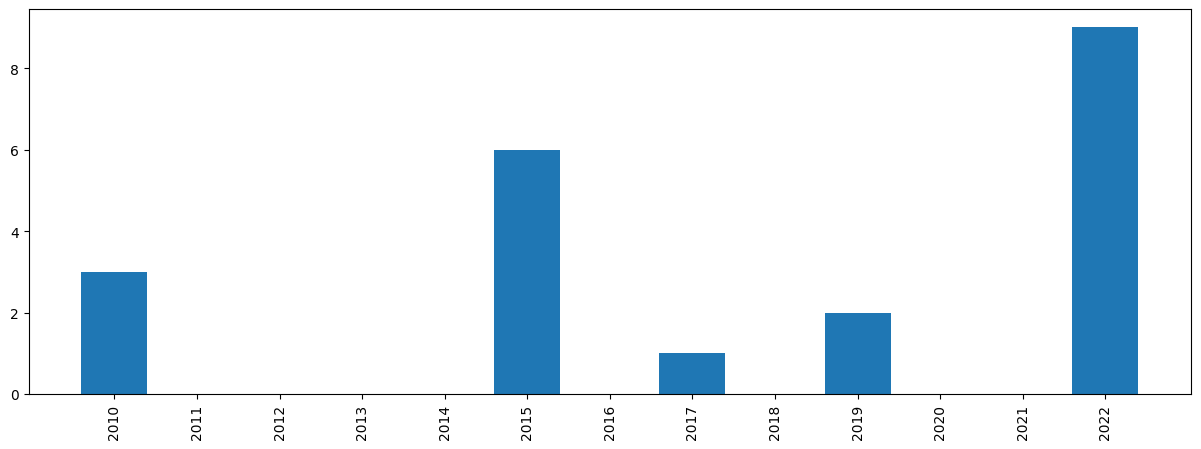

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

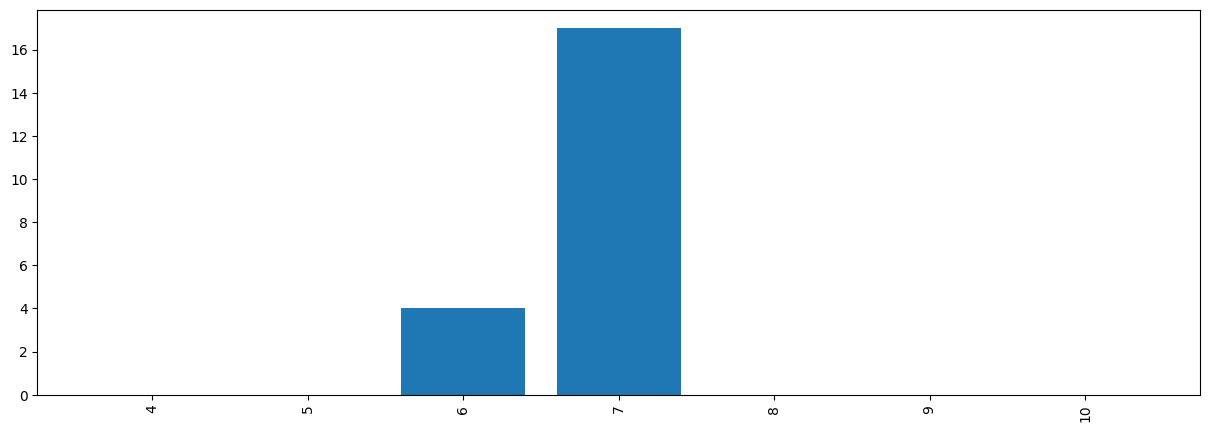

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

### Dummy for the high mean temperature

In [ ]:
data_120_temp = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_temp_obs,
    "dummy_miss": dummy_temp_miss,
    "sampling_type": 0  # 0 for poisson, 1 for rejection, 2 for hard cap, 3 for truncated poisson
}

fit_120_temp = model_120_dummy.sample(data=data_120_temp, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_temp = az.from_cmdstanpy(fit_120_temp)

21:53:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 01:26 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 02:06 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 02:32 Iteration: 200 / 1000 [ 20%]  (Warmup)

chain 1 |████▏     | 02:55 Iteration: 300 / 1000 [ 30%]  (Warmup)



chain 1 |█████▊    | 03:22 Iteration: 500 / 1000 [ 50%]  (Warmup)




chain 1 |██████▋   | 04:05 Iteration: 501 / 1000 [ 50%]  (Sampling)





chain 1 |███████▌  | 04:46 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 05:21 Iteration: 700 / 1000 [ 70%]  (Sampling)



chain 1 |█████████▏| 05:51 Iteration: 800 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 06:12 Sampling completed                      
chain 2 |██████████| 06:12 Sampling completed                      
chain 3 |██████████| 06:12 Sampling completed                      
chain 4 |██████████| 06:12 Sampling completed                      


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] =

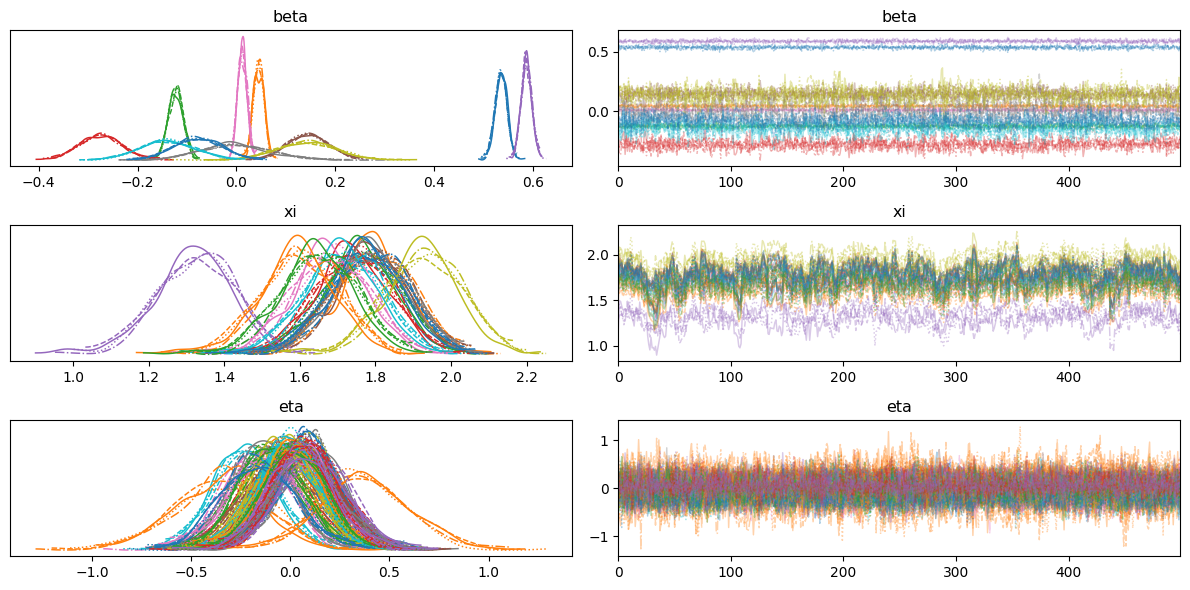

In [ ]:
az.plot_trace(posterior_120_temp, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_temp

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

array([[<Axes: title={'center': 'dummy_beta'}>,
        <Axes: title={'center': 'dummy_beta'}>]], dtype=object)

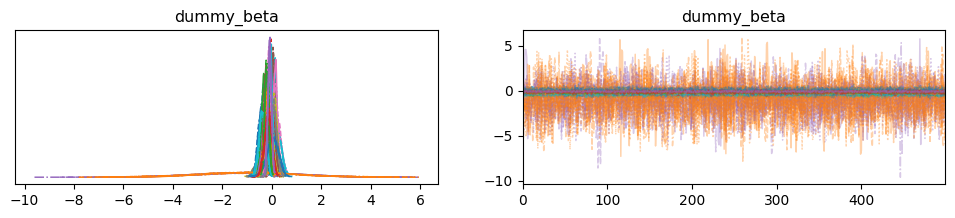

In [ ]:
az.plot_trace(posterior_120_temp, var_names=['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_temp_med = posterior_120_temp.posterior.median(dim=["chain", "draw"])
posterior_120_temp_med

array([-0.209669  , -0.0820168 , -0.280194  ,  0.02887725, -0.3473785 ,
       -0.04204595,  0.210964  , -0.3019135 , -0.2858495 ,  0.17539   ,
       -0.3146875 , -0.969801  ,  0.06975655, -0.236298  , -0.983939  ,
        0.1061665 , -0.0842535 ,  0.0609948 , -0.2828175 ,  0.1150275 ,
       -0.00948024, -0.09808885, -0.1612755 , -0.02380055, -0.241758  ,
        0.05886965,  0.1422095 , -0.29616   ,  0.0950889 , -0.04543935,
       -0.414609  , -0.9587415 , -0.318544  , -0.178105  , -0.234544  ,
       -0.2349015 , -0.1116405 ,  0.07336665, -0.1075155 , -0.366226  ,
        0.03794745, -0.189125  , -0.197949  , -0.1378625 , -0.0840458 ])

In [ ]:
y_star = posterior_120_temp.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_120_temp.posterior.y_pred.quantile(0.975, dim=["chain", "draw"])
y_star_low = posterior_120_temp.posterior.y_pred.quantile(0.025, dim=["chain", "draw"])


y_star_miss = posterior_120_temp.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_120_temp.posterior.y_pred_miss.quantile(0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_120_temp.posterior.y_pred_miss.quantile(0.025, dim=["chain", "draw"])

# Recontructing original ordering of the data
y_star_total = pd.concat([pd.Series(y_star, index=Y_obs_index), pd.Series(y_star_miss, index=Y_miss_index)]).sort_index()
y_star_up_total = pd.concat([pd.Series(y_star_up, index=Y_obs_index), pd.Series(y_star_up_miss, index=Y_miss_index)]).sort_index()
y_star_low_total = pd.concat([pd.Series(y_star_low, index=Y_obs_index), pd.Series(y_star_low_miss, index=Y_miss_index)]).sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'ceil'

In [ ]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21   34   83  145  154  165  173  227  234  309  350  351  362  363
  385  391  394  396  404  410  413  414  420  422  429  430  433  472
  478  479  481  482  486  488  493  512  513  519  581  582  585  588
  599  609  618  643  650  662  665  669  680  682  685  689  690  695
  701  718  753  757  769  770  771  774  775  781  799  802  807  824
  835  863  864  869  874  876  877  884  898  917  918  919  920  921
  931  950  955  962  984 1009 1012 1016 1019 1021 1022 1026 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1283 1317
 1329 1331 1341 1371 1384 1385 1407 1408 1409 1527 1535 1539 1540 1552
 1553 1563 1611 1631 1639 1647 1667 1765 1774 1786 1802 1824 1834 1848
 1859 1867 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978
 1983 1989 2008 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134
 2137 2140 2144 2180 2198 2221 2227 2234 2238 2241 2251 2291 2301 2315
 2327 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465
 2495 

In [ ]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

[   3  591  674  867 1387 2139 2387 2648 2655 2699 2713 2734 2735 2906
 3035 3122 3423 3545 3656 3757 3788]
(21,)
[ 391  410  429  478  585  599  695  701  769  770  876  884  920  950
 1016 1021 1222 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399
 2648 2666 2699 2718 2734 2749 2761 2832 2833 2839 2988 3014 3028 3095
 3140 3161 3522 3526 3607 3694]
(48,)


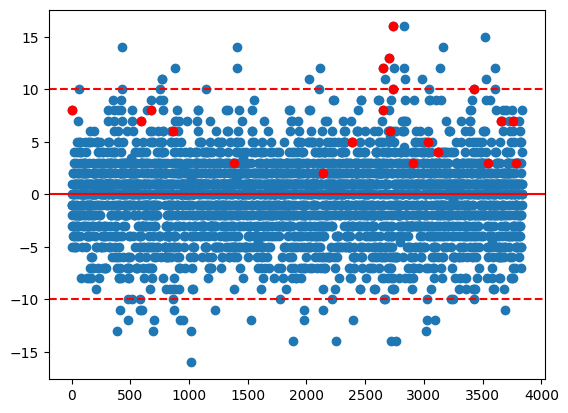

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.73658854)
<xarray.DataArray ()>
array(13.42923177)


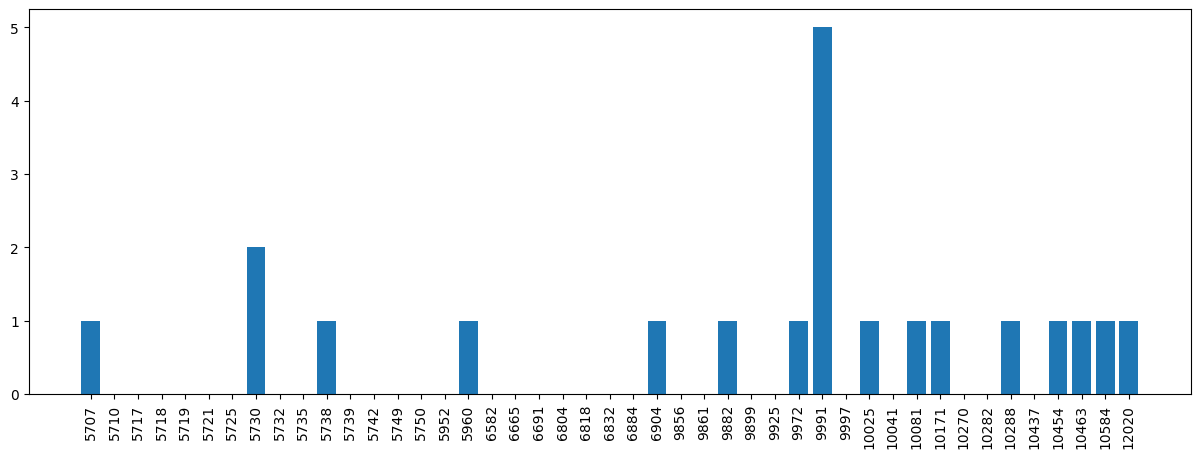

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

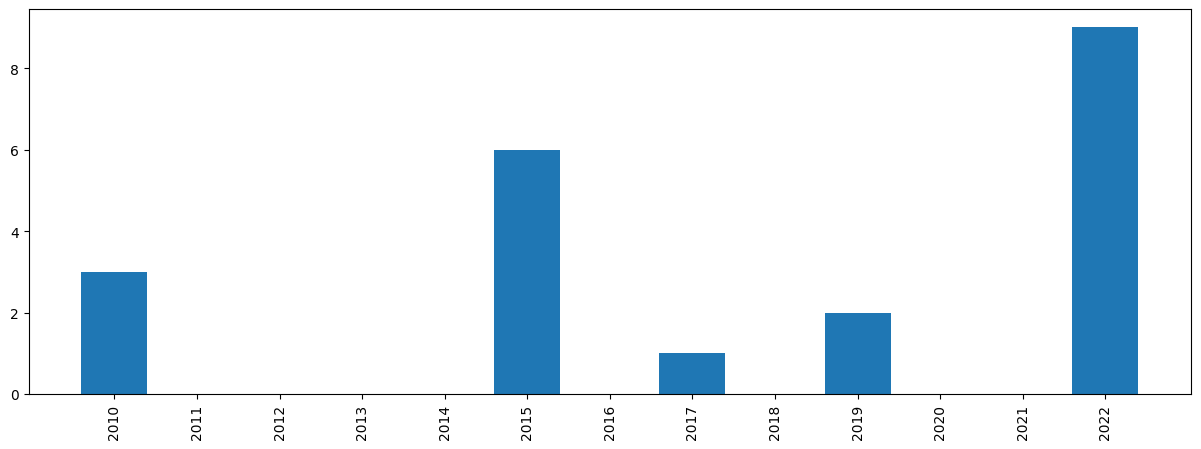

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

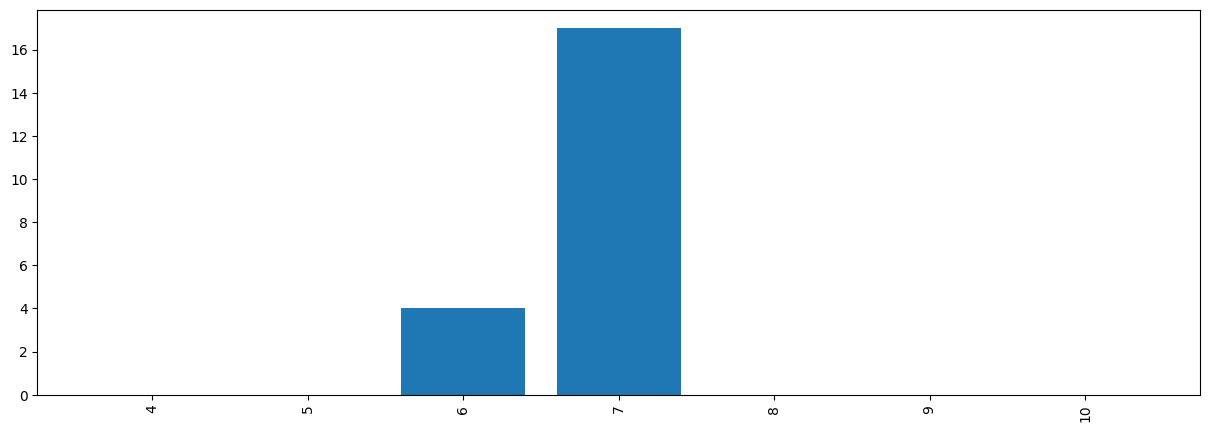

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

### Dummy for the low precipitation sum

In [ ]:
data_120_prec_sum = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_prec_sum_obs,
    "dummy_miss": dummy_prec_sum_miss,
    "sampling_type": 0  # 0 for poisson, 1 for rejection, 2 for hard cap, 3 for truncated poisson
}

fit_120_prec_sum = model_120_dummy.sample(data=data_120_prec_sum, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_prec_sum = az.from_cmdstanpy(fit_120_prec_sum)

21:53:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 01:26 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 02:06 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 02:32 Iteration: 200 / 1000 [ 20%]  (Warmup)

chain 1 |████▏     | 02:55 Iteration: 300 / 1000 [ 30%]  (Warmup)



chain 1 |█████▊    | 03:22 Iteration: 500 / 1000 [ 50%]  (Warmup)




chain 1 |██████▋   | 04:05 Iteration: 501 / 1000 [ 50%]  (Sampling)





chain 1 |███████▌  | 04:46 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 05:21 Iteration: 700 / 1000 [ 70%]  (Sampling)



chain 1 |█████████▏| 05:51 Iteration: 800 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 06:12 Sampling completed                      
chain 2 |██████████| 06:12 Sampling completed                      
chain 3 |██████████| 06:12 Sampling completed                      
chain 4 |██████████| 06:12 Sampling completed                      


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] =

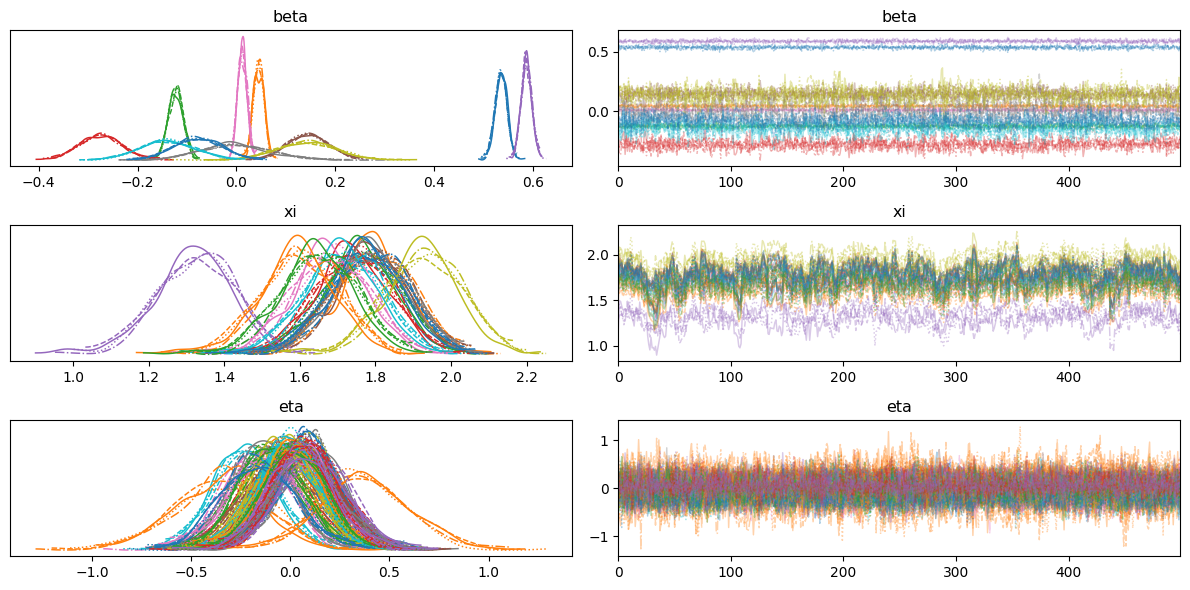

In [ ]:
az.plot_trace(posterior_120_prec_sum, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_prec_sum

In [ ]:
az.plot_trace(posterior_120_prec_sum, var_names=['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_prec_sum_med = posterior_120_prec_sum.posterior.median(dim=["chain", "draw"])
posterior_120_prec_sum_med

In [ ]:
y_star = posterior_120_prec_sum.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_120_prec_sum.posterior.y_pred.quantile(0.975, dim=["chain", "draw"])
y_star_low = posterior_120_prec_sum.posterior.y_pred.quantile(0.025, dim=["chain", "draw"])

y_star_miss = posterior_120_prec_sum.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_120_prec_sum.posterior.y_pred_miss.quantile(0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_120_prec_sum.posterior.y_pred_miss.quantile(0.025, dim=["chain", "draw"])

# Recontructing original ordering of the data
y_star_total = pd.concat([pd.Series(y_star, index=Y_obs_index), pd.Series(y_star_miss, index=Y_miss_index)]).sort_index()
y_star_up_total = pd.concat([pd.Series(y_star_up, index=Y_obs_index), pd.Series(y_star_up_miss, index=Y_miss_index)]).sort_index()
y_star_low_total = pd.concat([pd.Series(y_star_low, index=Y_obs_index), pd.Series(y_star_low_miss, index=Y_miss_index)]).sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200)
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()

In [ ]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21   34   83  145  154  165  173  227  234  309  350  351  362  363
  385  391  394  396  404  410  413  414  420  422  429  430  433  472
  478  479  481  482  486  488  493  512  513  519  581  582  585  588
  599  609  618  643  650  662  665  669  680  682  685  689  690  695
  701  718  753  757  769  770  771  774  775  781  799  802  807  824
  835  863  864  869  874  876  877  884  898  917  918  919  920  921
  931  950  955  962  984 1009 1012 1016 1019 1021 1022 1026 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1283 1317
 1329 1331 1341 1371 1384 1385 1407 1408 1409 1527 1535 1539 1540 1552
 1553 1563 1611 1631 1639 1647 1667 1765 1774 1786 1802 1824 1834 1848
 1859 1867 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978
 1983 1989 2008 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134
 2137 2140 2144 2180 2198 2221 2227 2234 2238 2241 2251 2291 2301 2315
 2327 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465
 2495 

In [ ]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

[   3  591  674  867 1387 2139 2387 2648 2655 2699 2713 2734 2735 2906
 3035 3122 3423 3545 3656 3757 3788]
(21,)
[ 391  410  429  478  585  599  695  701  769  770  876  884  920  950
 1016 1021 1222 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399
 2648 2666 2699 2718 2734 2749 2761 2832 2833 2839 2988 3014 3028 3095
 3140 3161 3522 3526 3607 3694]
(48,)


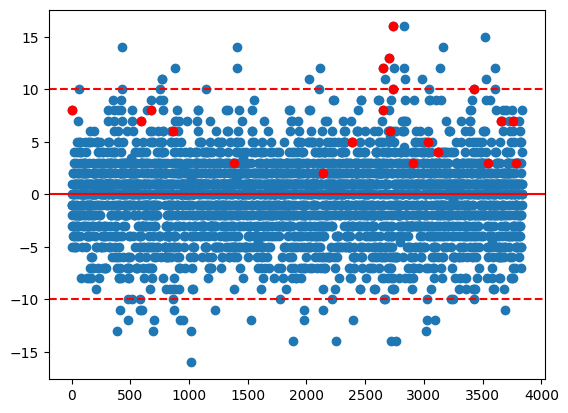

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.73658854)
<xarray.DataArray ()>
array(13.42923177)


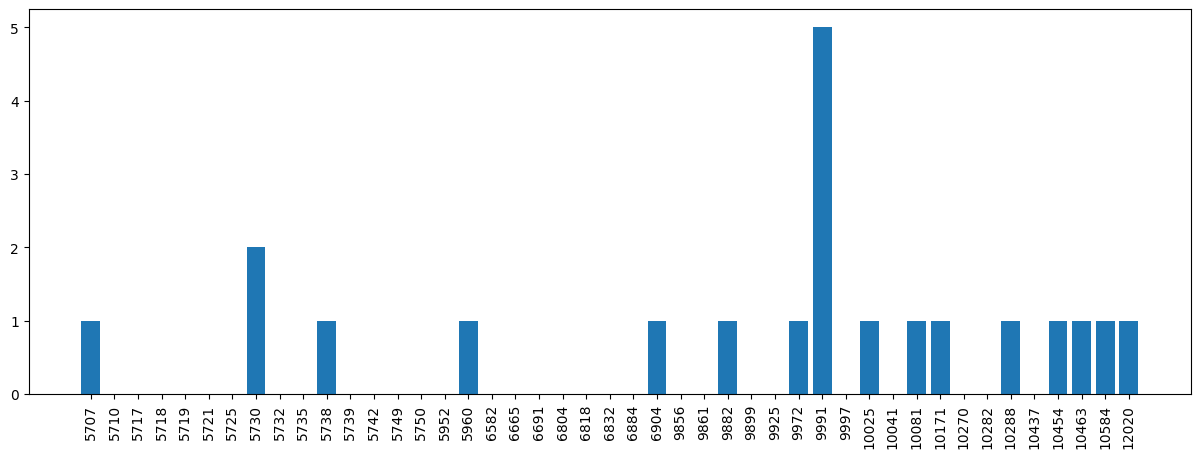

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

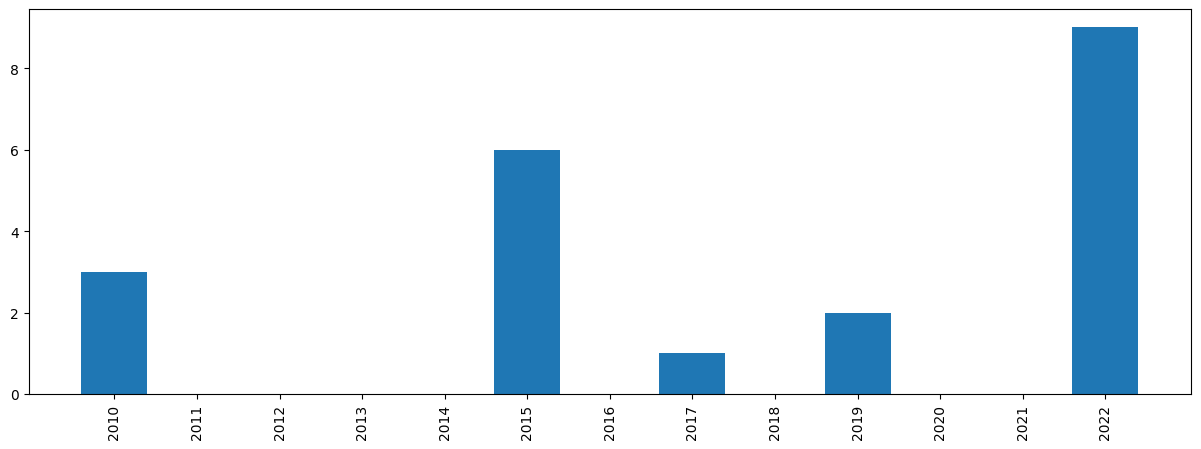

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

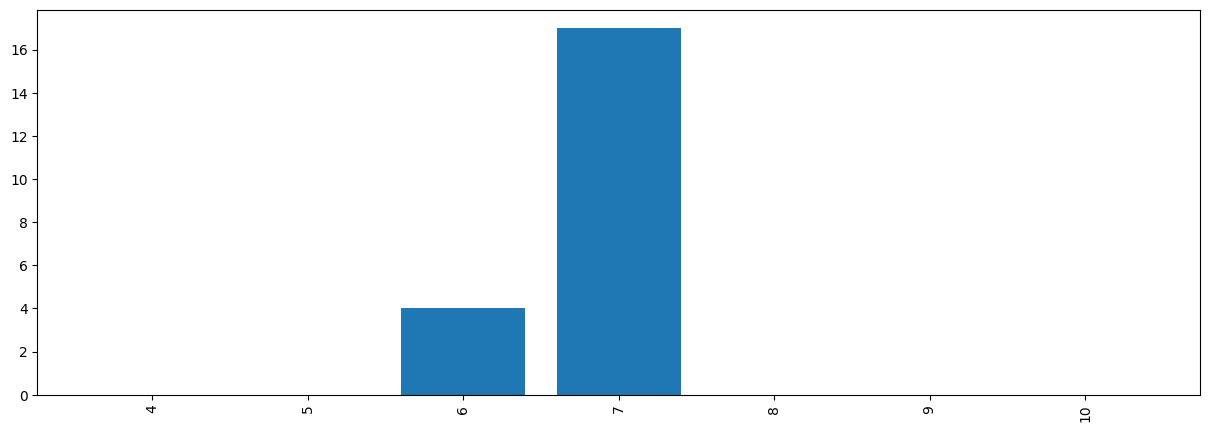

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

### Dummy for the low precipitation hours

In [ ]:
data_120_prec_hours = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_prec_hours_obs,
    "dummy_miss": dummy_prec_hours_miss,
    "sampling_type": 0  # 0 for poisson, 1 for rejection, 2 for hard cap, 3 for truncated poisson
}

fit_120_prec_hours = model_120_dummy.sample(data=data_120_prec_hours, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_prec_hours = az.from_cmdstanpy(fit_120_prec_hours)

21:53:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 01:26 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 02:06 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 02:32 Iteration: 200 / 1000 [ 20%]  (Warmup)

chain 1 |████▏     | 02:55 Iteration: 300 / 1000 [ 30%]  (Warmup)



chain 1 |█████▊    | 03:22 Iteration: 500 / 1000 [ 50%]  (Warmup)




chain 1 |██████▋   | 04:05 Iteration: 501 / 1000 [ 50%]  (Sampling)





chain 1 |███████▌  | 04:46 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 05:21 Iteration: 700 / 1000 [ 70%]  (Sampling)



chain 1 |█████████▏| 05:51 Iteration: 800 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 06:12 Sampling completed                      
chain 2 |██████████| 06:12 Sampling completed                      
chain 3 |██████████| 06:12 Sampling completed                      
chain 4 |██████████| 06:12 Sampling completed                      


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] =

In [ ]:
az.plot_trace(posterior_120_prec_hours, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_prec_hours

In [ ]:
az.plot_trace(posterior_120_prec_hours, var_names=['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_prec_hours_med = posterior_120_prec_hours.posterior.median(dim=["chain", "draw"])
posterior_120_prec_hours_med

In [ ]:
y_star = posterior_120_prec_hours.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_120_prec_hours.posterior.y_pred.quantile(0.975, dim=["chain", "draw"])
y_star_low = posterior_120_prec_hours.posterior.y_pred.quantile(0.025, dim=["chain", "draw"])

y_star_miss = posterior_120_prec_hours.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_120_prec_hours.posterior.y_pred_miss.quantile(0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_120_prec_hours.posterior.y_pred_miss.quantile(0.025, dim=["chain", "draw"])

# Recontructing original ordering of the data
y_star_total = pd.concat([pd.Series(y_star, index=Y_obs_index), pd.Series(y_star_miss, index=Y_miss_index)]).sort_index()
y_star_up_total = pd.concat([pd.Series(y_star_up, index=Y_obs_index), pd.Series(y_star_up_miss, index=Y_miss_index)]).sort_index()
y_star_low_total = pd.concat([pd.Series(y_star_low, index=Y_obs_index), pd.Series(y_star_low_miss, index=Y_miss_index)]).sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200)
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()

In [ ]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21   34   83  145  154  165  173  227  234  309  350  351  362  363
  385  391  394  396  404  410  413  414  420  422  429  430  433  472
  478  479  481  482  486  488  493  512  513  519  581  582  585  588
  599  609  618  643  650  662  665  669  680  682  685  689  690  695
  701  718  753  757  769  770  771  774  775  781  799  802  807  824
  835  863  864  869  874  876  877  884  898  917  918  919  920  921
  931  950  955  962  984 1009 1012 1016 1019 1021 1022 1026 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1283 1317
 1329 1331 1341 1371 1384 1385 1407 1408 1409 1527 1535 1539 1540 1552
 1553 1563 1611 1631 1639 1647 1667 1765 1774 1786 1802 1824 1834 1848
 1859 1867 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978
 1983 1989 2008 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134
 2137 2140 2144 2180 2198 2221 2227 2234 2238 2241 2251 2291 2301 2315
 2327 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465
 2495 

In [ ]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

[   3  591  674  867 1387 2139 2387 2648 2655 2699 2713 2734 2735 2906
 3035 3122 3423 3545 3656 3757 3788]
(21,)
[ 391  410  429  478  585  599  695  701  769  770  876  884  920  950
 1016 1021 1222 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399
 2648 2666 2699 2718 2734 2749 2761 2832 2833 2839 2988 3014 3028 3095
 3140 3161 3522 3526 3607 3694]
(48,)


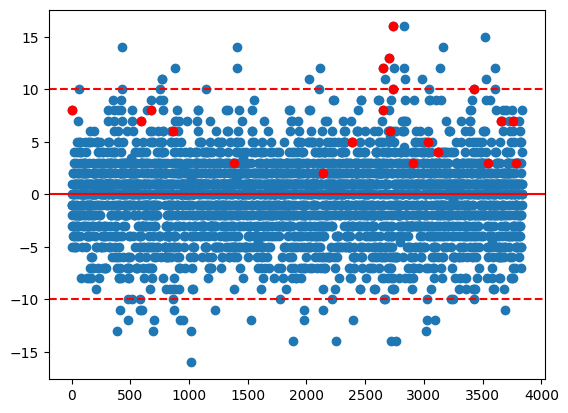

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.73658854)
<xarray.DataArray ()>
array(13.42923177)


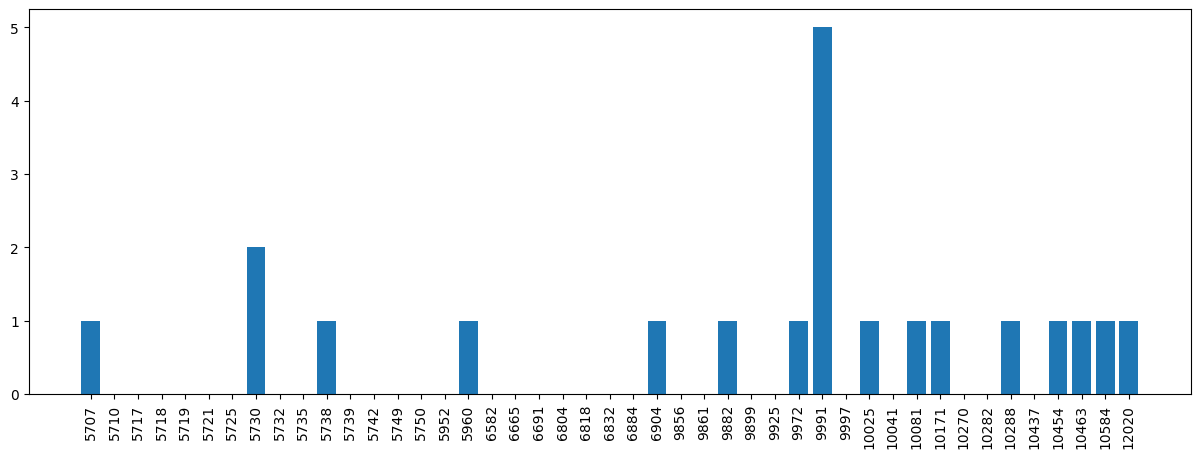

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

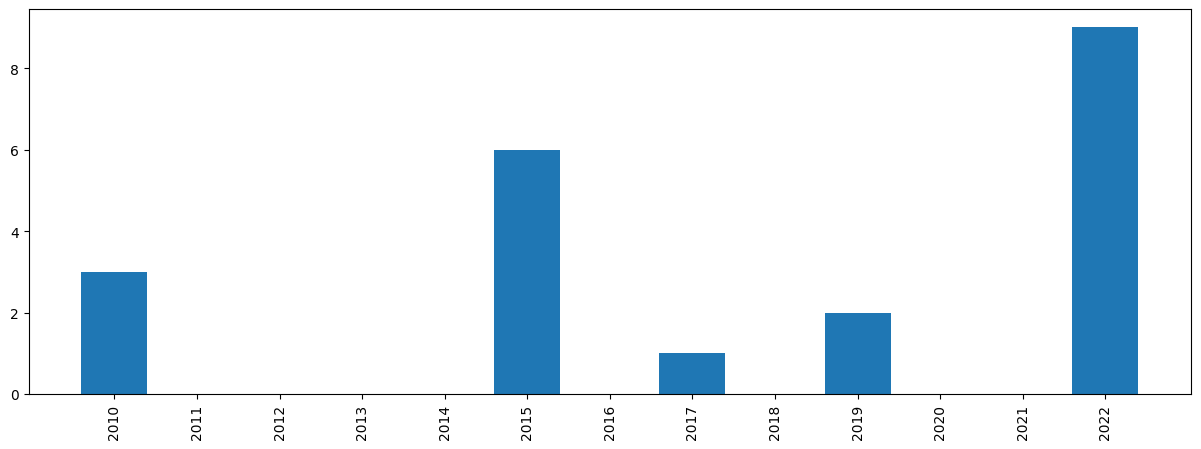

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

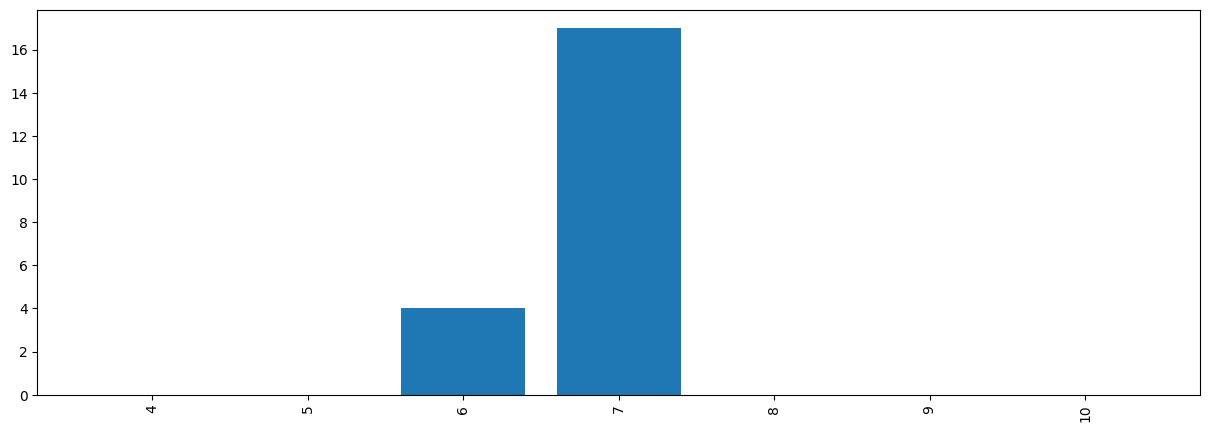

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

### Dummy for high radiation

In [ ]:
data_120_rad = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_rad_obs,
    "dummy_miss": dummy_rad_miss,
    "sampling_type": 0  # 0 for poisson, 1 for rejection, 2 for hard cap, 3 for truncated poisson
}

fit_120_rad = model_120_dummy.sample(data=data_120_rad, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_rad = az.from_cmdstanpy(fit_120_rad)

21:53:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 01:26 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 02:06 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 02:32 Iteration: 200 / 1000 [ 20%]  (Warmup)

chain 1 |████▏     | 02:55 Iteration: 300 / 1000 [ 30%]  (Warmup)



chain 1 |█████▊    | 03:22 Iteration: 500 / 1000 [ 50%]  (Warmup)




chain 1 |██████▋   | 04:05 Iteration: 501 / 1000 [ 50%]  (Sampling)





chain 1 |███████▌  | 04:46 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 05:21 Iteration: 700 / 1000 [ 70%]  (Sampling)



chain 1 |█████████▏| 05:51 Iteration: 800 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 06:12 Sampling completed                      
chain 2 |██████████| 06:12 Sampling completed                      
chain 3 |██████████| 06:12 Sampling completed                      
chain 4 |██████████| 06:12 Sampling completed                      


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] =

In [ ]:
az.plot_trace(posterior_120_rad, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_rad

In [ ]:
az.plot_trace(posterior_120_rad, var_names=['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_rad_med = posterior_120_rad.posterior.median(dim=["chain", "draw"])
posterior_120_rad_med

In [ ]:
y_star = posterior_120_rad.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_120_rad.posterior.y_pred.quantile(0.975, dim=["chain", "draw"])
y_star_low = posterior_120_rad.posterior.y_pred.quantile(0.025, dim=["chain", "draw"])

y_star_miss = posterior_120_rad.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_120_rad.posterior.y_pred_miss.quantile(0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_120_rad.posterior.y_pred_miss.quantile(0.025, dim=["chain", "draw"])

# Recontructing original ordering of the data
y_star_total = pd.concat([pd.Series(y_star, index=Y_obs_index), pd.Series(y_star_miss, index=Y_miss_index)]).sort_index()
y_star_up_total = pd.concat([pd.Series(y_star_up, index=Y_obs_index), pd.Series(y_star_up_miss, index=Y_miss_index)]).sort_index()
y_star_low_total = pd.concat([pd.Series(y_star_low, index=Y_obs_index), pd.Series(y_star_low_miss, index=Y_miss_index)]).sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200)
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()

In [ ]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21   34   83  145  154  165  173  227  234  309  350  351  362  363
  385  391  394  396  404  410  413  414  420  422  429  430  433  472
  478  479  481  482  486  488  493  512  513  519  581  582  585  588
  599  609  618  643  650  662  665  669  680  682  685  689  690  695
  701  718  753  757  769  770  771  774  775  781  799  802  807  824
  835  863  864  869  874  876  877  884  898  917  918  919  920  921
  931  950  955  962  984 1009 1012 1016 1019 1021 1022 1026 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1283 1317
 1329 1331 1341 1371 1384 1385 1407 1408 1409 1527 1535 1539 1540 1552
 1553 1563 1611 1631 1639 1647 1667 1765 1774 1786 1802 1824 1834 1848
 1859 1867 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978
 1983 1989 2008 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134
 2137 2140 2144 2180 2198 2221 2227 2234 2238 2241 2251 2291 2301 2315
 2327 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465
 2495 

In [ ]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

[   3  591  674  867 1387 2139 2387 2648 2655 2699 2713 2734 2735 2906
 3035 3122 3423 3545 3656 3757 3788]
(21,)
[ 391  410  429  478  585  599  695  701  769  770  876  884  920  950
 1016 1021 1222 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399
 2648 2666 2699 2718 2734 2749 2761 2832 2833 2839 2988 3014 3028 3095
 3140 3161 3522 3526 3607 3694]
(48,)


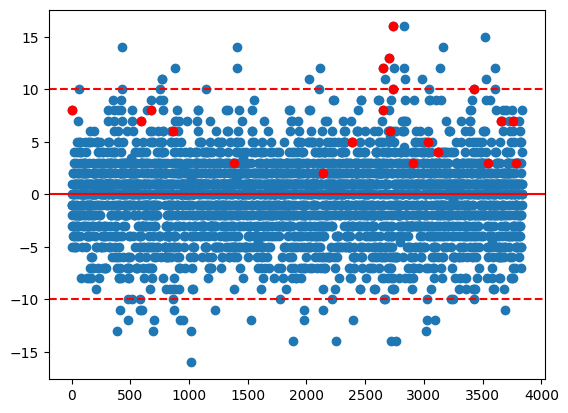

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.73658854)
<xarray.DataArray ()>
array(13.42923177)


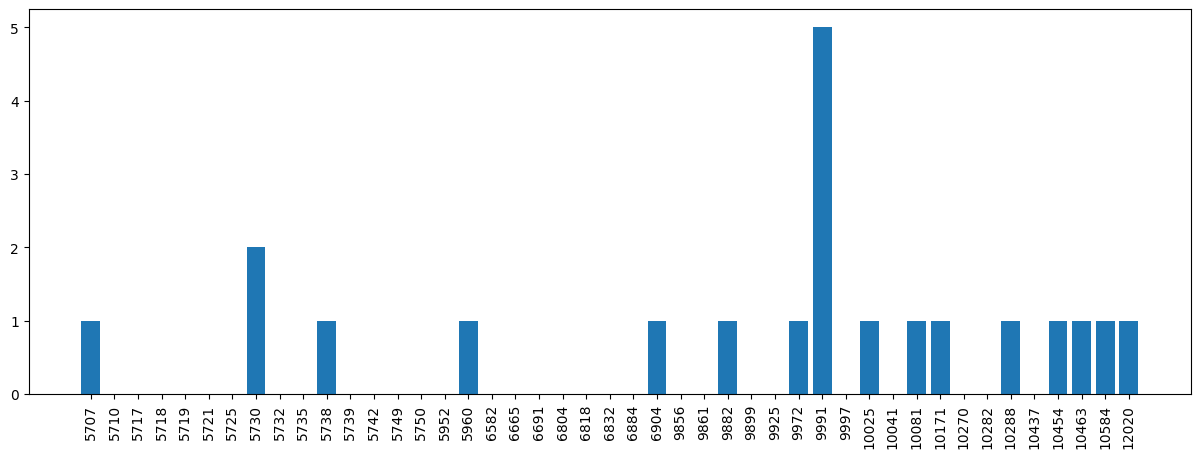

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

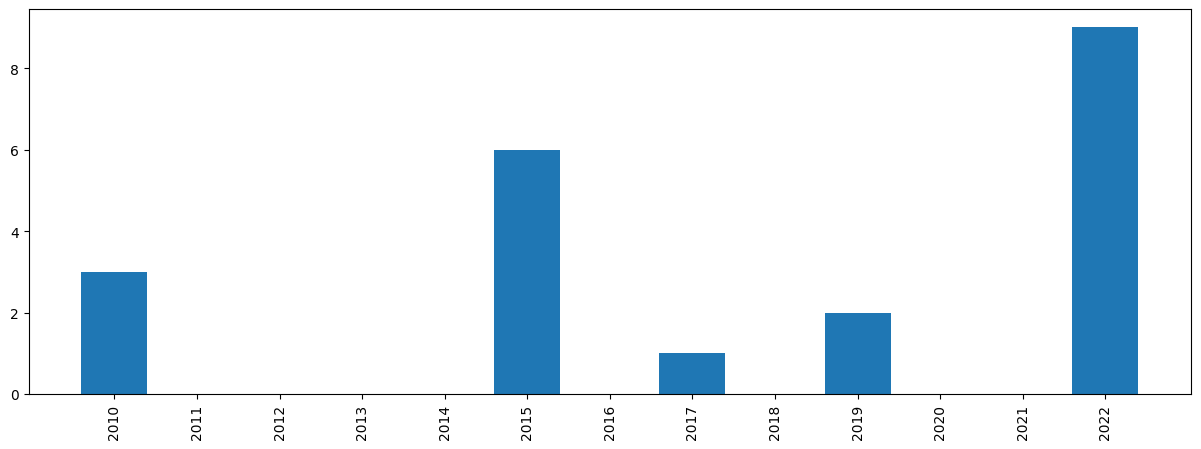

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

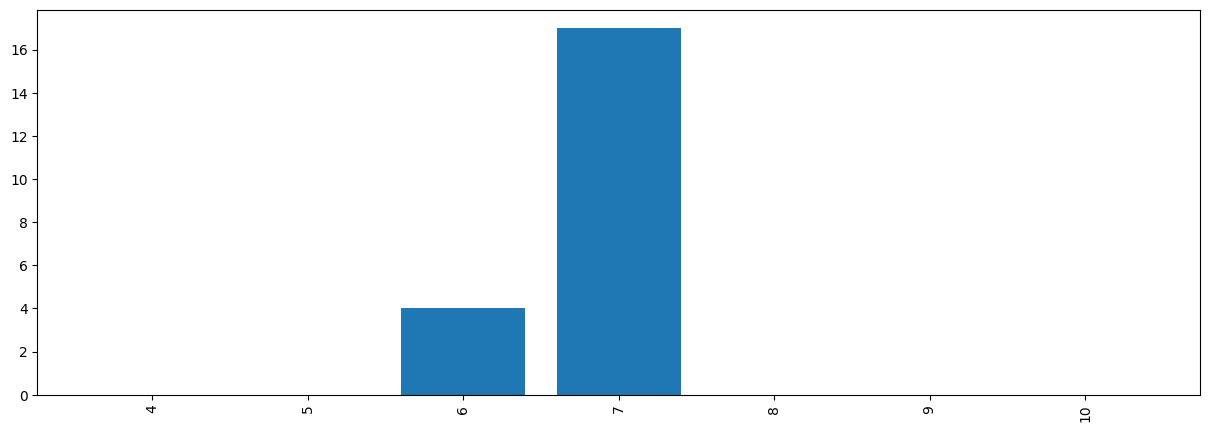

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

### Dummy that indicates the simultaneous triggering of the previous dummies except the july one

In [ ]:
data_120_cov_inter = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_cov_inter_obs,
    "dummy_miss": dummy_cov_inter_miss,
    "sampling_type": 0  # 0 for poisson, 1 for rejection, 2 for hard cap, 3 for truncated poisson
}

fit_120_cov_inter = model_120_dummy.sample(data=data_120_cov_inter, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_cov_inter = az.from_cmdstanpy(fit_120_cov_inter)

21:53:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 01:26 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 02:06 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 02:32 Iteration: 200 / 1000 [ 20%]  (Warmup)

chain 1 |████▏     | 02:55 Iteration: 300 / 1000 [ 30%]  (Warmup)



chain 1 |█████▊    | 03:22 Iteration: 500 / 1000 [ 50%]  (Warmup)




chain 1 |██████▋   | 04:05 Iteration: 501 / 1000 [ 50%]  (Sampling)





chain 1 |███████▌  | 04:46 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 05:21 Iteration: 700 / 1000 [ 70%]  (Sampling)



chain 1 |█████████▏| 05:51 Iteration: 800 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 06:12 Sampling completed                      
chain 2 |██████████| 06:12 Sampling completed                      
chain 3 |██████████| 06:12 Sampling completed                      
chain 4 |██████████| 06:12 Sampling completed                      


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] =

In [ ]:
az.plot_trace(posterior_120_cov_inter, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_cov_inter

In [ ]:
az.plot_trace(posterior_120_cov_inter, var_names=['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_cov_inter_med = posterior_120_cov_inter.posterior.median(dim=["chain", "draw"])
posterior_120_cov_inter_med

In [ ]:
y_star = posterior_120_cov_inter.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_120_cov_inter.posterior.y_pred.quantile(0.975, dim=["chain", "draw"])
y_star_low = posterior_120_cov_inter.posterior.y_pred.quantile(0.025, dim=["chain", "draw"])

y_star_miss = posterior_120_cov_inter.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_120_cov_inter.posterior.y_pred_miss.quantile(0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_120_cov_inter.posterior.y_pred_miss.quantile(0.025, dim=["chain", "draw"])

# Recontructing original ordering of the data
y_star_total = pd.concat([pd.Series(y_star, index=Y_obs_index), pd.Series(y_star_miss, index=Y_miss_index)]).sort_index()
y_star_up_total = pd.concat([pd.Series(y_star_up, index=Y_obs_index), pd.Series(y_star_up_miss, index=Y_miss_index)]).sort_index()
y_star_low_total = pd.concat([pd.Series(y_star_low, index=Y_obs_index), pd.Series(y_star_low_miss, index=Y_miss_index)]).sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200)
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()

In [ ]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21   34   83  145  154  165  173  227  234  309  350  351  362  363
  385  391  394  396  404  410  413  414  420  422  429  430  433  472
  478  479  481  482  486  488  493  512  513  519  581  582  585  588
  599  609  618  643  650  662  665  669  680  682  685  689  690  695
  701  718  753  757  769  770  771  774  775  781  799  802  807  824
  835  863  864  869  874  876  877  884  898  917  918  919  920  921
  931  950  955  962  984 1009 1012 1016 1019 1021 1022 1026 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1283 1317
 1329 1331 1341 1371 1384 1385 1407 1408 1409 1527 1535 1539 1540 1552
 1553 1563 1611 1631 1639 1647 1667 1765 1774 1786 1802 1824 1834 1848
 1859 1867 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978
 1983 1989 2008 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134
 2137 2140 2144 2180 2198 2221 2227 2234 2238 2241 2251 2291 2301 2315
 2327 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465
 2495 

In [ ]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

[   3  591  674  867 1387 2139 2387 2648 2655 2699 2713 2734 2735 2906
 3035 3122 3423 3545 3656 3757 3788]
(21,)
[ 391  410  429  478  585  599  695  701  769  770  876  884  920  950
 1016 1021 1222 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399
 2648 2666 2699 2718 2734 2749 2761 2832 2833 2839 2988 3014 3028 3095
 3140 3161 3522 3526 3607 3694]
(48,)


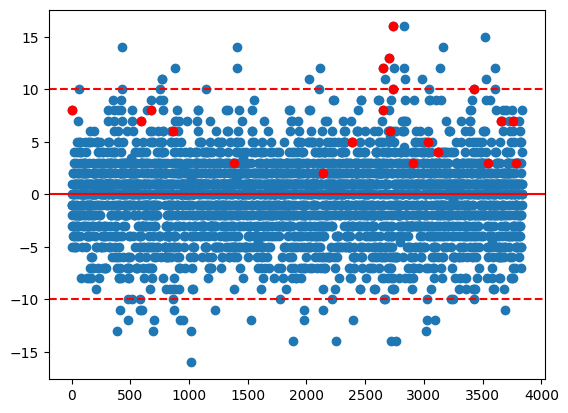

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.73658854)
<xarray.DataArray ()>
array(13.42923177)


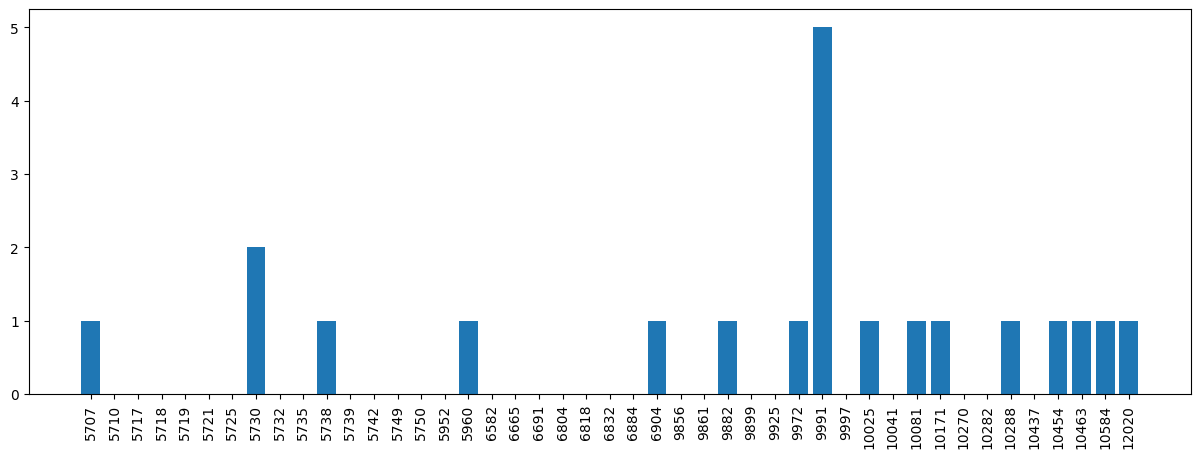

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

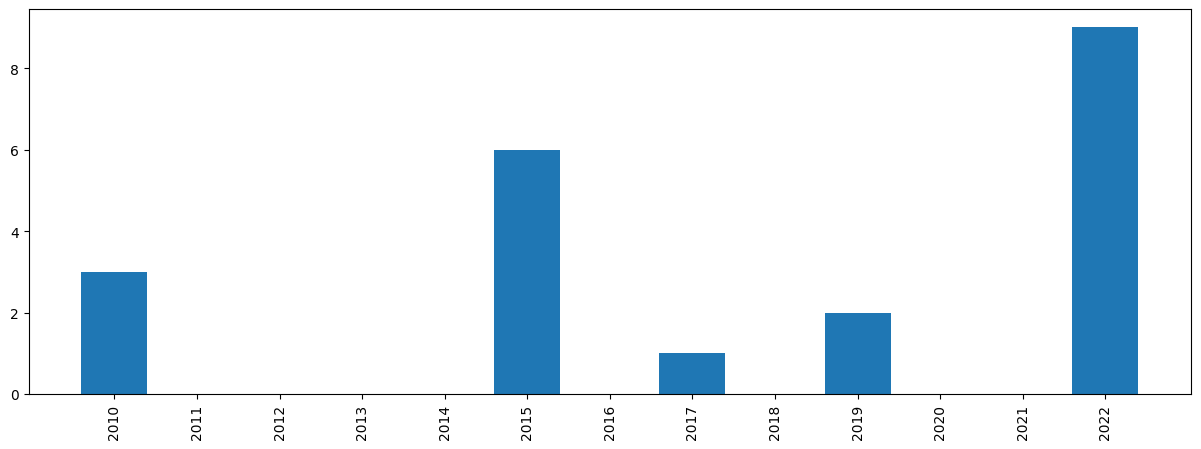

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

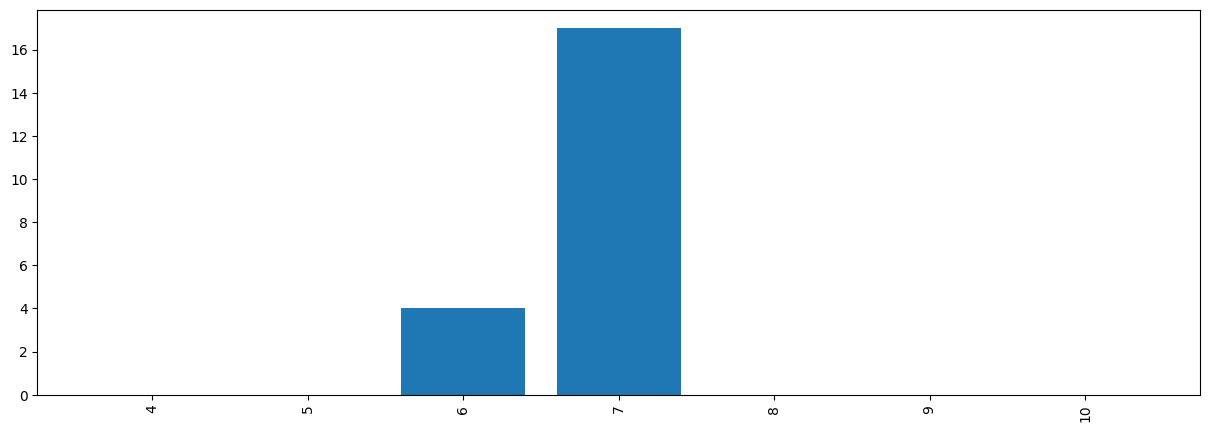

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

### Dummy that indicates the simultaneous triggering of the previous dummies including the july one

In [ ]:
data_120_tot_inter = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_tot_inter_obs,
    "dummy_miss": dummy_tot_inter_miss,
    "sampling_type": 0  # 0 for poisson, 1 for rejection, 2 for hard cap, 3 for truncated poisson
}

fit_120_tot_inter = model_120_dummy.sample(data=data_120_tot_inter, chains=4, parallel_chains=4, 
    iter_warmup=500, iter_sampling=500)
posterior_120_tot_inter = az.from_cmdstanpy(fit_120_tot_inter)

21:53:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▋        | 01:26 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 02:06 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 02:32 Iteration: 200 / 1000 [ 20%]  (Warmup)

chain 1 |████▏     | 02:55 Iteration: 300 / 1000 [ 30%]  (Warmup)



chain 1 |█████▊    | 03:22 Iteration: 500 / 1000 [ 50%]  (Warmup)




chain 1 |██████▋   | 04:05 Iteration: 501 / 1000 [ 50%]  (Sampling)





chain 1 |███████▌  | 04:46 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 05:21 Iteration: 700 / 1000 [ 70%]  (Sampling)



chain 1 |█████████▏| 05:51 Iteration: 800 / 1000 [ 80%]  (Sampling)

chain 1 |██████████| 06:12 Sampling completed                      
chain 2 |██████████| 06:12 Sampling completed                      
chain 3 |██████████| 06:12 Sampling completed                      
chain 4 |██████████| 06:12 Sampling completed                      


22:00:07 - cmdstanpy - INFO - CmdStan done processing.
22:00:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'out120.stan', line 60, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] =

In [ ]:
az.plot_trace(posterior_120_tot_inter, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_tot_inter

In [ ]:
az.plot_trace(posterior_120_tot_inter, var_names=['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
posterior_120_tot_inter_med = posterior_120_tot_inter.posterior.median(dim=["chain", "draw"])
posterior_120_tot_inter_med

In [ ]:
y_star = posterior_120_tot_inter.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_120_tot_inter.posterior.y_pred.quantile(0.975, dim=["chain", "draw"])
y_star_low = posterior_120_tot_inter.posterior.y_pred.quantile(0.025, dim=["chain", "draw"])

y_star_miss = posterior_120_tot_inter.posterior.y_pred_miss.median(dim=["chain", "draw"])
y_star_up_miss = posterior_120_tot_inter.posterior.y_pred_miss.quantile(0.975, dim=["chain", "draw"])
y_star_low_miss = posterior_120_tot_inter.posterior.y_pred_miss.quantile(0.025, dim=["chain", "draw"])

# Recontructing original ordering of the data
y_star_total = pd.concat([pd.Series(y_star, index=Y_obs_index), pd.Series(y_star_miss, index=Y_miss_index)]).sort_index()
y_star_up_total = pd.concat([pd.Series(y_star_up, index=Y_obs_index), pd.Series(y_star_up_miss, index=Y_miss_index)]).sort_index()
y_star_low_total = pd.concat([pd.Series(y_star_low, index=Y_obs_index), pd.Series(y_star_low_miss, index=Y_miss_index)]).sort_index()

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200)
plt.figure(figsize=(15, 5))
plt.plot(xx, y_star_total[xx], label='Predicted')
plt.fill_between(xx, y_star_low_total[xx], y_star_up_total[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Real')
plt.legend()
plt.show()

In [ ]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21   34   83  145  154  165  173  227  234  309  350  351  362  363
  385  391  394  396  404  410  413  414  420  422  429  430  433  472
  478  479  481  482  486  488  493  512  513  519  581  582  585  588
  599  609  618  643  650  662  665  669  680  682  685  689  690  695
  701  718  753  757  769  770  771  774  775  781  799  802  807  824
  835  863  864  869  874  876  877  884  898  917  918  919  920  921
  931  950  955  962  984 1009 1012 1016 1019 1021 1022 1026 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195 1222 1283 1317
 1329 1331 1341 1371 1384 1385 1407 1408 1409 1527 1535 1539 1540 1552
 1553 1563 1611 1631 1639 1647 1667 1765 1774 1786 1802 1824 1834 1848
 1859 1867 1869 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978
 1983 1989 2008 2026 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134
 2137 2140 2144 2180 2198 2221 2227 2234 2238 2241 2251 2291 2301 2315
 2327 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465
 2495 

In [ ]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

[   3  591  674  867 1387 2139 2387 2648 2655 2699 2713 2734 2735 2906
 3035 3122 3423 3545 3656 3757 3788]
(21,)
[ 391  410  429  478  585  599  695  701  769  770  876  884  920  950
 1016 1021 1222 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399
 2648 2666 2699 2718 2734 2749 2761 2832 2833 2839 2988 3014 3028 3095
 3140 3161 3522 3526 3607 3694]
(48,)


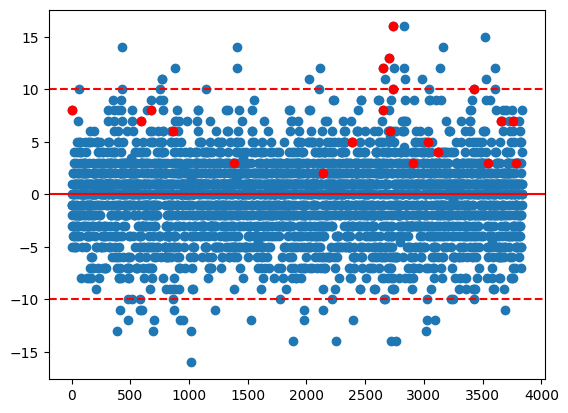

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

<xarray.DataArray ()>
array(2.73658854)
<xarray.DataArray ()>
array(13.42923177)


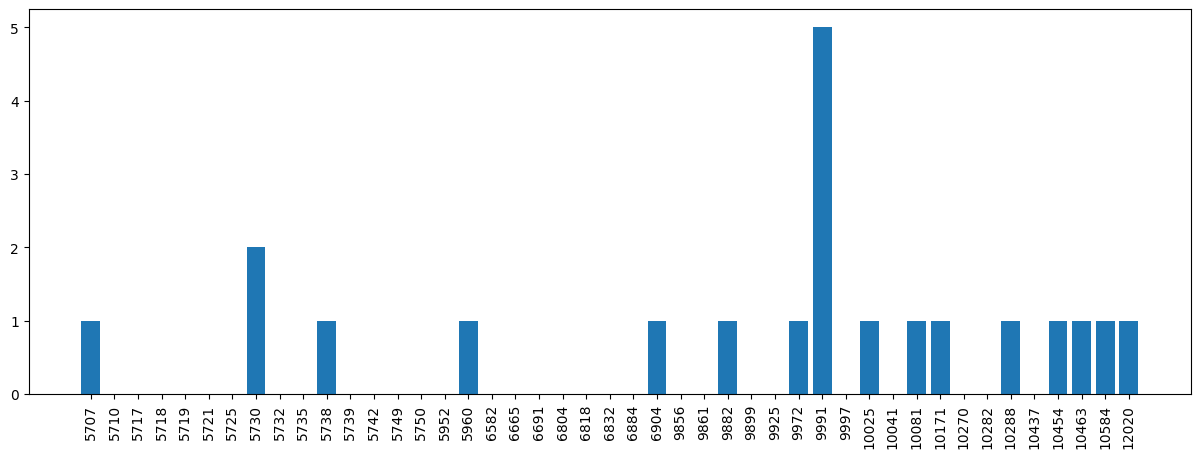

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

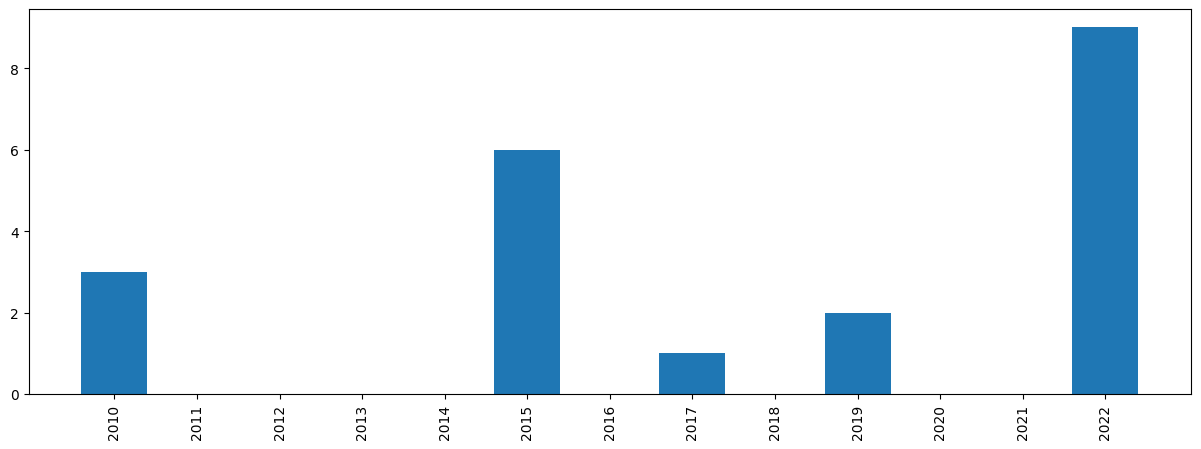

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

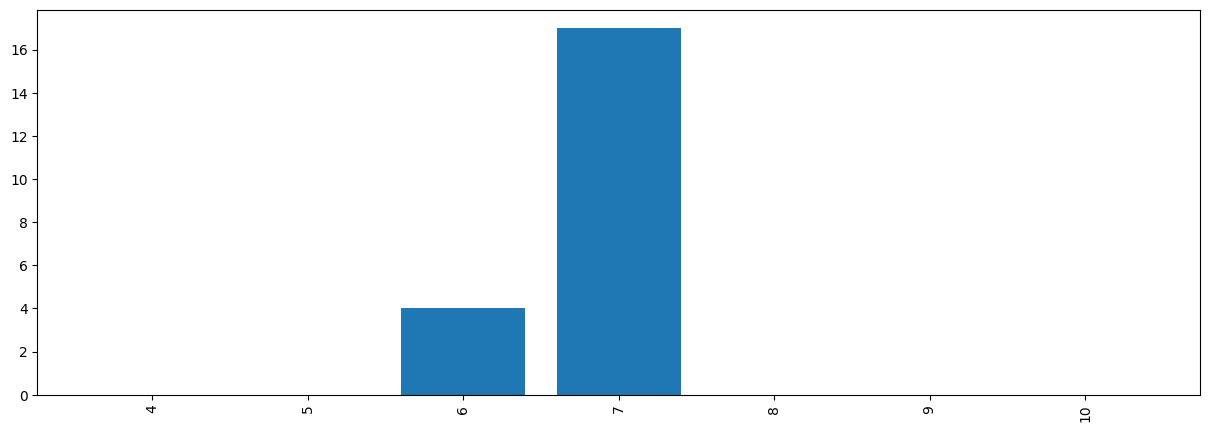

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()